In [1]:
# Import all the needful packages-----------------------
import numpy as np
import pandas as pd
import pandas_profiling

from matplotlib import pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

pd.set_option('display.max_columns', 100) 
# ------------------------------------------------------

In [2]:
# Read the CSV file using 
carsales_df = pd.read_csv("https://raw.githubusercontent.com/insaid2018/Term-1/master/Data/Projects/car_sales.csv", encoding='cp1252')

In [3]:
carsales_df.shape

(9576, 10)

In [4]:
carsales_df.info() # Details about Dataframe index, Column Name, Non-null Count, and Datatype of the column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9576 entries, 0 to 9575
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car           9576 non-null   object 
 1   price         9576 non-null   float64
 2   body          9576 non-null   object 
 3   mileage       9576 non-null   int64  
 4   engV          9142 non-null   float64
 5   engType       9576 non-null   object 
 6   registration  9576 non-null   object 
 7   year          9576 non-null   int64  
 8   model         9576 non-null   object 
 9   drive         9065 non-null   object 
dtypes: float64(2), int64(2), object(6)
memory usage: 748.2+ KB


In [5]:
carsales_df.describe() # Describes the Data of the DataSet. Statistics of DatSet, Min, Max, Inter Quartile Ranges for all quantitative variables

,price,mileage,engV,year
count,9576.000000,9576.000000,9142.000000,9576.000000
mean,15633.317316,138.862364,2.646344,2006.605994
std,24106.523436,98.629754,5.927699,7.067924
min,0.000000,0.000000,0.100000,1953.000000
25%,4999.000000,70.000000,1.600000,2004.000000
50%,9200.000000,128.000000,2.000000,2008.000000
75%,16700.000000,194.000000,2.500000,2012.000000
max,547800.000000,999.000000,99.990000,2016.000000


From this Describe function gives us basic statistics computed on the dataset
* Among the 4 numerical columns, engine has less values in count (all are 9756 except engV). There could be some missing data which should be cleansed.
* *Price* & *Mileage* is having min value as '0', which looks incorrect or outlier. Could be potential candidate for correction/discard the data

In [6]:
carsales_df.isnull().sum()

car               0
price             0
body              0
mileage           0
engV            434
engType           0
registration      0
year              0
model             0
drive           511
dtype: int64

* We can observe engV and drive is missing/null values. 
* These missing or null values we cant replace with any default value

In [7]:
carsales_Profile = pandas_profiling.ProfileReport(carsales_df)
carsales_Profile.to_file("CarSales_Before_Processing.html")

## The profiing report describes
* There are 113 duplicated rows (Action - Remove the duplcates)
* 1% of missing cells are in the dataset (Action - Replace with default/mean value or discard the record)
* 5 Categorical variables, 4 numeric variables and 1 boolean value

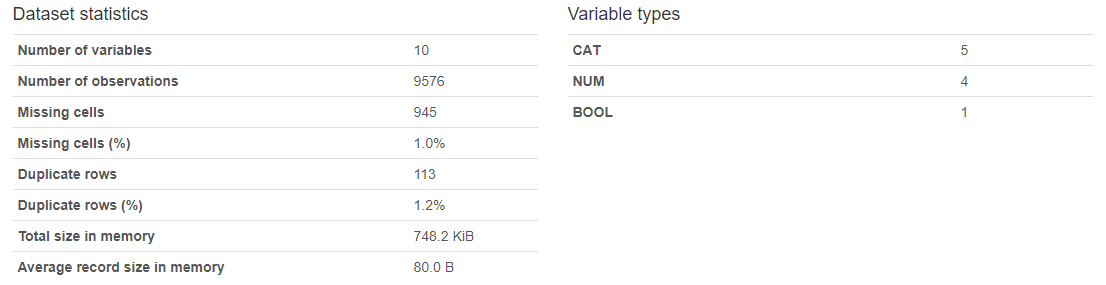


# <div style="text-align:center;background: -webkit-linear-gradient(#fff, #888);-webkit-background-clip: text;-webkit-text-fill-color: transparent;"> Data Processing </div>


* Removing the duplicates (113 records identified)
* Numerical Values to be fixed.
    * engV - after removing duplicates there are **434** entries has '0' price value which seems like incorrect
        * Queries
            * carsales_df.engV.describe()
            * carsales_df[carsales_df.engV == 0].car.count()
            
    * price - after removing duplicates there are **240** entries has '0' price value which seems like incorrect
        * Queries
            * carsales_df.price.describe()
            * carsales_df[carsales_df.price == 0].car.count()
            
    * mileage - - after removing duplicates there are **310** entries has '0' mileage value which seems like incorrect
        * Queries
            * carsales_df.mileage.describe()
            * carsales_df[carsales_df.mileage == 0].car.count()
            
* Categorical Values to be fixed
    * Drive
    * engType

In [8]:
# lets Drop the duplicate Value

carsales_df.drop_duplicates(inplace=True)
carsales_df.shape

(9463, 10)

<AxesSubplot:ylabel='Frequency'>

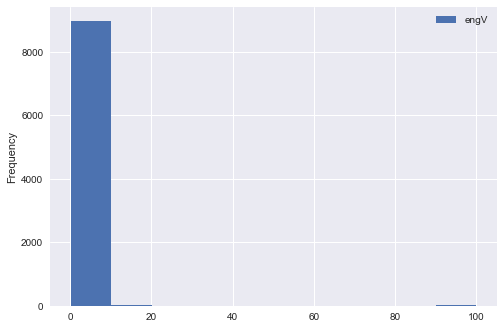

In [9]:
pd.DataFrame(carsales_df['engV']).plot.hist()

# Fixing *engV* missing / erroneous values

In [10]:
'''
Function that removes the ourlier entries of engV and returns dataframe
'''
def exclude_outliers_for_engV():
    return pd.DataFrame(carsales_df[(carsales_df.engV > 0.5) & (carsales_df.engV < 25)])



'''
Function that computes the mean value of engV based on make and model 
'''
def compute_engV_mean(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return round(r.mean(),2)
    else:
        engV_df = exclude_outliers_for_engV()
        engV_make = engV_df[engV_df.car == car_make].engV
        if engV_make.count() > 0:
            return round(engV_make.mean(),2)
        else:
            return round(engV_df.engV.mean(),2)
        
'''
Create a staging "engV mean" dataframe for  all combinations of make and model
'''
engV_mean = carsales_df.groupby(['car','model']).engV.apply(compute_engV_mean).reset_index()
engV_mean.rename(columns={'engV':'engV_avg'}, inplace=True)
engV_mean.head(10)

,car,model,engV_avg
0,Acura,MDX,3.62
1,Acura,RL,3.50
2,Acura,TL,3.20
3,Acura,TLX,2.40
4,Acura,ZDX,3.70
5,Alfa Romeo,147,1.60
6,Alfa Romeo,156,1.85
7,Alfa Romeo,159,2.20
8,Alfa Romeo,33,1.70
9,Alfa Romeo,75,1.60


In [11]:
'''
Function that return engV value for missing records
'''
def get_missing_engV(r):
    if pd.isnull(r.engV):
        return engV_mean[(engV_mean.car == r.car) & (engV_mean.model == r.model)].engV_avg.values[0]
    else:
        return r.engV
    

'''
Fix the missing engV values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.engV.isnull()].shape)

carsales_df.engV = carsales_df.apply(get_missing_engV, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.engV.isnull()].shape)

--------------Before fix-----------------
(434, 10)
--------------After fix -----------------
(0, 10)


# Fixing *price* missing / erroneous values

In [12]:
'''
Function that computes the median value of price based on make and model 
'''
def compute_price_median(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if (r.count() > 0) & (r.median() > 0):
        return r.median()
    else:
        price_make = carsales_df[carsales_df.car == car_make].price
        if price_make.median() > 0:
            return price_make.median()
        else:
            return carsales_df.price.median()

        
'''
Create a staging "Price median" dataframe for  all combinations of make and model
'''
price_median = carsales_df.groupby(['car','model']).price.apply(compute_price_median).reset_index()
price_median.rename(columns={'price':'price_median'}, inplace=True)
price_median.head(10)

,car,model,price_median
0,Acura,MDX,17200.0
1,Acura,RL,13950.0
2,Acura,TL,8699.0
3,Acura,TLX,38200.0
4,Acura,ZDX,30999.0
5,Alfa Romeo,147,5900.0
6,Alfa Romeo,156,2325.0
7,Alfa Romeo,159,12050.0
8,Alfa Romeo,33,1800.0
9,Alfa Romeo,75,2300.0


In [13]:
'''
Function that return price value for missing records
'''
def get_missing_price(r):
    if r.price == 0:
        return price_median[(price_median.car == r.car) & (price_median.model == r.model)].price_median.values[0]
    else:
        return r.price
    

'''
Fix the missing price values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.price == 0].shape)

carsales_df.price = carsales_df.apply(get_missing_price, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.price == 0].shape)

--------------Before fix-----------------
(240, 10)
--------------After fix -----------------
(0, 10)


# Fixing *mileage* missing / erroneous values

In [14]:
'''
Function that computes the median value of mileage based on make and model 
'''
def compute_mileage_median(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if (r.count() > 0) & (r.median() > 0):
        return r.median()
    else:
        mileage_make = carsales_df[carsales_df.car == car_make].mileage
        if mileage_make.median() > 0:
            return mileage_make.median()
        else:
            return carsales_df.mileage.median()
        

        '''
Create a staging "mileage median" dataframe for  all combinations of make and model
'''
mileage_median = carsales_df.groupby(['car','model']).mileage.apply(compute_mileage_median).reset_index()
mileage_median.rename(columns={'mileage':'mileage_median'}, inplace=True)
mileage_median.head(10)

,car,model,mileage_median
0,Acura,MDX,85.0
1,Acura,RL,138.0
2,Acura,TL,145.0
3,Acura,TLX,4.0
4,Acura,ZDX,32.0
5,Alfa Romeo,147,199.0
6,Alfa Romeo,156,162.0
7,Alfa Romeo,159,120.5
8,Alfa Romeo,33,185.0
9,Alfa Romeo,75,122.0


In [15]:
'''
Function that return mileage value for missing records
'''
def get_missing_mileage(r):
    if r.mileage == 0:
        return mileage_median[(mileage_median.car == r.car) & (mileage_median.model == r.model)].mileage_median.values[0]
    else:
        return r.mileage
    

'''
Fix the missing price values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.mileage == 0].shape)

carsales_df.mileage = carsales_df.apply(get_missing_mileage, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.mileage == 0].shape)

--------------Before fix-----------------
(310, 10)
--------------After fix -----------------
(0, 10)


# Fixing *drive* missing / erroneous values

In [16]:
'''
Function that removes the null entries of drive and returns dataframe
'''
def get_clensed_data_for_drive():
    return pd.DataFrame(carsales_df[carsales_df.drive.isnull() == False])


'''
Function that computes the mode value of drive based on make and model 
'''
def compute_drive(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return r.mode()
    else:
        drive_df = get_clensed_data_for_drive()
        drive_make = drive_df[drive_df.car == car_make].drive
        if drive_make.count() > 0:
            return drive_make.mode()
        else:
            return drive_df.drive.mode()
        
        
'''
Create a staging "drive mode" dataframe for  all combinations of make and model
'''
drive_mode = carsales_df.groupby(['car','model']).drive.apply(compute_drive).reset_index()
drive_mode.rename(columns={'drive':'drive_mode'}, inplace=True)
drive_mode.drop('level_2', axis=1)

,car,model,drive_mode
0,Acura,MDX,full
1,Acura,RL,full
2,Acura,TL,front
3,Acura,TLX,front
4,Acura,ZDX,full
...,...,...,...
914,ZX,LandMark,full
915,ËUAZ,1301,full
916,ËUAZ,1302,full
917,ËUAZ,969 Âîëûíü,full


In [17]:
'''
Function that return drive value for missing records
'''
def get_missing_drive(r):
    if pd.isnull(r.drive):
        return drive_mode[(drive_mode.car == r.car) & (drive_mode.model == r.model)].drive_mode.values[0]
    else:
        return r.drive
    
'''
Fix the missing drive values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

carsales_df.drive = carsales_df.apply(get_missing_drive, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.drive.isnull()].shape)

--------------Before fix-----------------
(510, 10)
--------------After fix -----------------
(0, 10)


# Fixing *engType* missing / erroneous values

In [18]:
'''
Function that removes the null entries of engType and returns dataframe
'''
def get_clensed_data_for_engType():
    return pd.DataFrame(carsales_df[carsales_df.engType.isnull() == False])


'''
Function that computes the mode value of drive based on make and model 
'''
def compute_engType(r):
    car_make = r.name[0]    
    car_model = r.name[1]
    if r.count() > 0:
        return r.mode()
    else:
        engType_df = get_clensed_data_for_engType()
        engType_make = engType_df[engType_df.car == car_make].engType
        if engType_make.count() > 0:
            return engType_make.mode()
        else:
            return engType_df.engType.mode()
        
        
'''
Create a staging "engType mode" dataframe for  all combinations of make and model
'''
engType_mode = carsales_df.groupby(['car','model']).engType.apply(compute_engType).reset_index()
engType_mode.rename(columns={'engType':'engType_mode'}, inplace=True)
engType_mode.drop('level_2', axis=1)

,car,model,engType_mode
0,Acura,MDX,Petrol
1,Acura,RL,Gas
2,Acura,TL,Gas
3,Acura,TLX,Petrol
4,Acura,ZDX,Other
...,...,...,...
984,ZX,LandMark,Petrol
985,ËUAZ,1301,Petrol
986,ËUAZ,1302,Gas
987,ËUAZ,969 Âîëûíü,Petrol


In [19]:
'''
Function that return drive value for missing records
'''
def get_missing_engType(r):
    if pd.isnull(r.engType):
        return engType_mode[(engType_mode.car == r.car) & (engType_mode.model == r.model)].engType_mode.values[0]
    else:
        return r.engType
    
'''
Fix the missing engType values
'''
print('--------------Before fix-----------------')
print(carsales_df[carsales_df.engType.isnull()].shape)

carsales_df.engType = carsales_df.apply(get_missing_engType, axis=1)
print('--------------After fix -----------------')
print(carsales_df[carsales_df.engType.isnull()].shape)

--------------Before fix-----------------
(0, 10)
--------------After fix -----------------
(0, 10)


In [20]:
carsales_Profile = pandas_profiling.ProfileReport(carsales_df)
carsales_Profile.to_file("CarSales_Post_Processing.html")

### CarSales dataset stats  & warnings

Stats:
--------
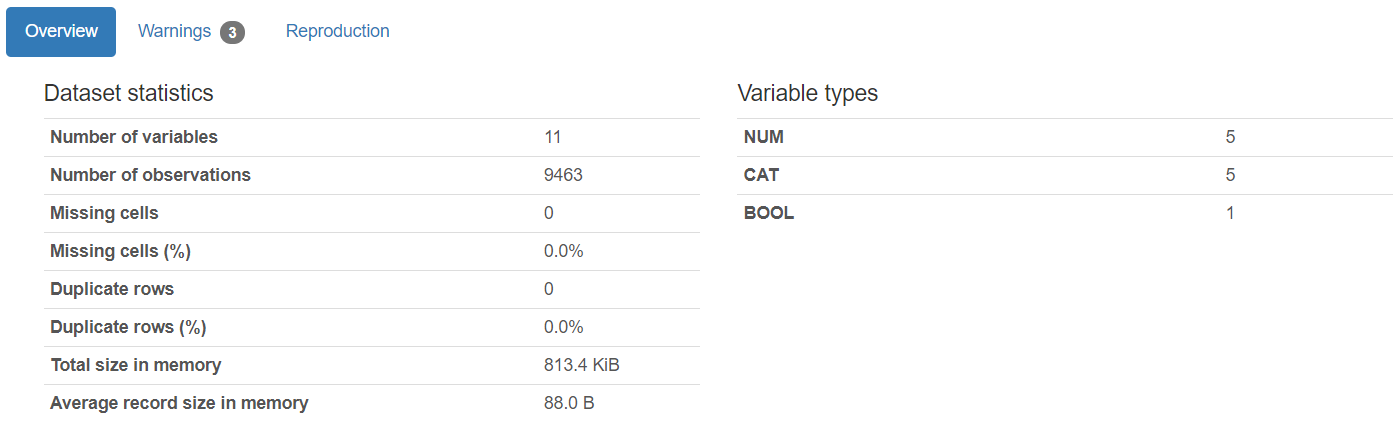


Warnings:
--------------
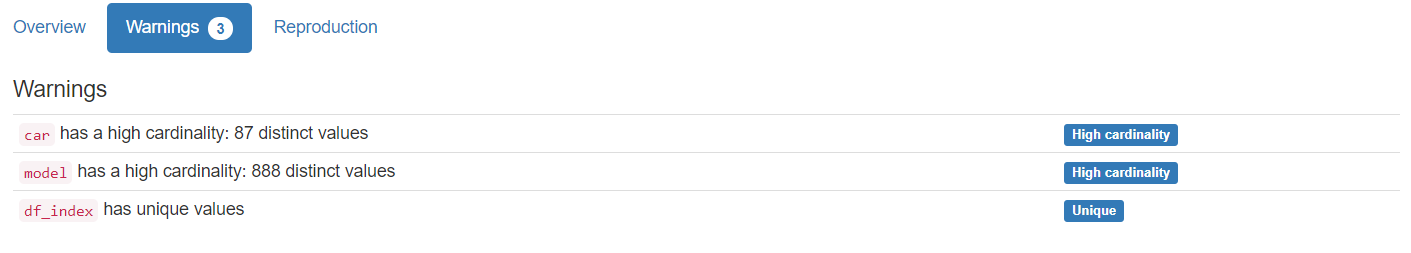

From the above observations, it looks the Carsales dataset is cleansed/processed correctly. 
* no missing values
* no duplicate records

Lets start visualizing the data. 

# <div style="text-align:center;background: -webkit-linear-gradient(#fff, #888);-webkit-background-clip: text;-webkit-text-fill-color: transparent;"> EDA </div>


In [21]:
carsales_df

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68.0,2.50,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173.0,1.80,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135.0,5.50,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162.0,1.80,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91.0,2.57,Other,yes,2013,E-Class,rear
...,...,...,...,...,...,...,...,...,...,...
9571,Hyundai,14500.0,crossover,140.0,2.00,Gas,yes,2011,Tucson,front
9572,Volkswagen,2200.0,vagon,150.0,1.60,Petrol,yes,1986,Passat B2,front
9573,Mercedes-Benz,18500.0,crossover,180.0,3.50,Petrol,yes,2008,ML 350,full
9574,Lexus,16999.0,sedan,150.0,3.50,Gas,yes,2008,ES 350,front


In [22]:
import matplotlib.pyplot as plt

In [23]:
type(carsales_df.car.value_counts())

pandas.core.series.Series

In [24]:
# plot a graph on both series and dataframe

df = pd.DataFrame(carsales_df.car.value_counts())
df

,car
Volkswagen,927
Mercedes-Benz,885
BMW,684
Toyota,529
VAZ,488
...,...
FAW,1
Maserati,1
Buick,1
Huanghai,1


<AxesSubplot:>

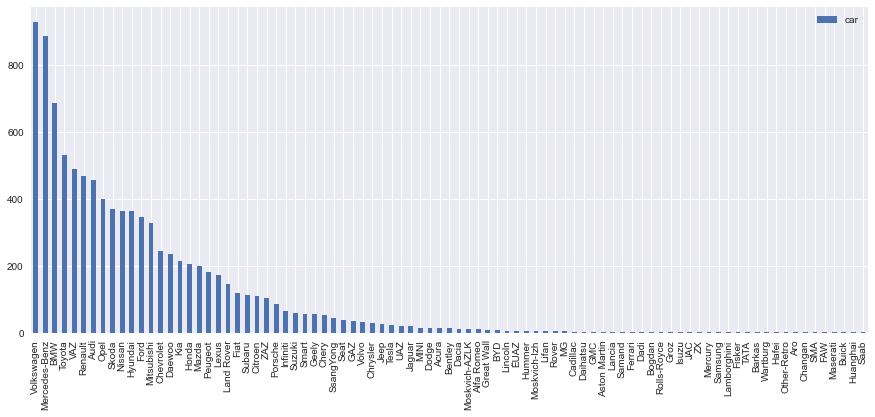

In [25]:
df.plot.bar(figsize=(15,6))

<AxesSubplot:>

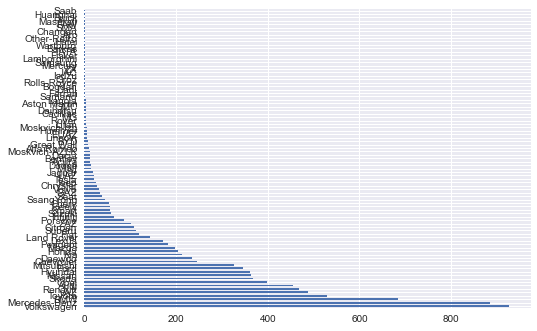

In [26]:
carsales_df.car.value_counts().plot.barh()

<AxesSubplot:>

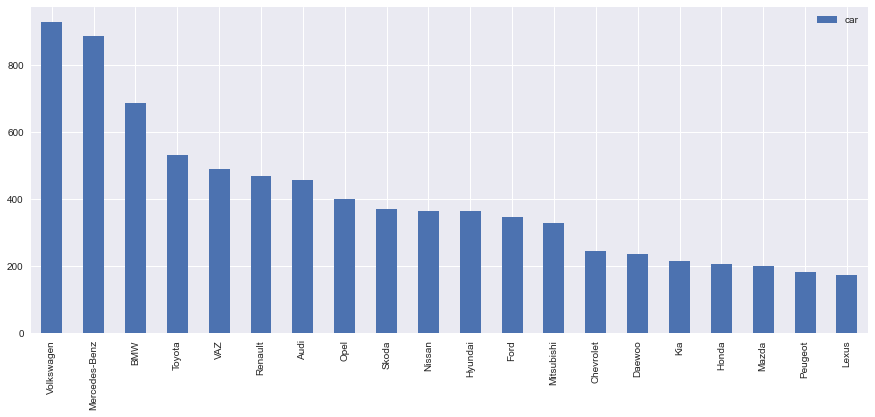

In [27]:
df.head(20).plot.bar(figsize=(15,6))

<AxesSubplot:>

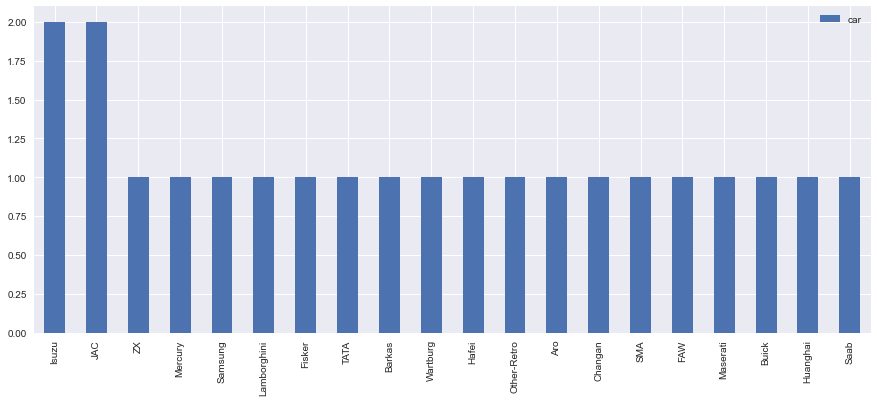

In [28]:
df.tail(20).plot.bar(figsize=(15,6))

In [29]:
carsales_df.price.nlargest()

7621    547800.0
1611    499999.0
2637    449999.0
4134    449999.0
4325    300000.0
Name: price, dtype: float64

In [30]:
carsales_df.price.nlargest(10)

7621    547800.0
1611    499999.0
2637    449999.0
4134    449999.0
4325    300000.0
5849    300000.0
1891    295000.0
2165    295000.0
8205    285000.0
1478    259000.0
Name: price, dtype: float64

In [31]:
carsales_df[carsales_df['car'] == 'Ford']

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68.0,2.5,Gas,yes,2010,Kuga,full
210,Ford,15500.0,crossover,68.0,2.5,Diesel,yes,2010,Kuga,front
280,Ford,12500.0,sedan,63.0,1.6,Petrol,yes,2013,Focus,front
313,Ford,12099.0,sedan,109.0,1.6,Gas,yes,2011,Focus,front
317,Ford,12300.0,hatch,71.0,1.6,Gas,yes,2013,Fiesta,front
...,...,...,...,...,...,...,...,...,...,...
9456,Ford,17700.0,crossover,67.0,2.5,Petrol,yes,2012,Kuga,full
9493,Ford,5500.0,sedan,215.0,2.0,Petrol,yes,2006,Mondeo,front
9494,Ford,7100.0,hatch,70.0,1.6,Petrol,yes,2006,Focus,front
9529,Ford,1200.0,sedan,3.0,2.0,Petrol,yes,1986,Sierra,rear


In [32]:
carsales_df[carsales_df.price.isin([500, 1000])].head()

,car,price,body,mileage,engV,engType,registration,year,model,drive
1671,ZAZ,1000.0,hatch,150.0,1.2,Petrol,yes,2004,1102 Òàâðèÿ,front
1686,Ford,1000.0,hatch,2.0,1.4,Petrol,yes,1985,Fiesta,front
3956,VAZ,1000.0,sedan,200.0,1.6,Petrol,yes,1978,2106,rear
6422,GAZ,500.0,sedan,239.0,2.0,Other,yes,1961,21,rear
7061,UAZ,1000.0,crossover,3.0,2.4,Petrol,yes,1986,469Á,full


In [33]:
carsales_df[carsales_df.price.isin(carsales_df.price.nlargest())]

,car,price,body,mileage,engV,engType,registration,year,model,drive
1611,Bentley,499999.0,crossover,20.0,6.00,Petrol,yes,2016,Bentayga,full
2637,Bentley,449999.0,crossover,1.0,6.00,Petrol,yes,2016,Bentayga,full
4134,Bentley,449999.0,crossover,20.0,6.00,Petrol,yes,2016,Bentayga,full
4325,Mercedes-Benz,300000.0,sedan,68.0,6.00,Petrol,yes,2011,S 600,rear
5849,Mercedes-Benz,300000.0,other,37.0,5.00,Petrol,yes,2012,G 500,full
7621,Bentley,547800.0,sedan,20.0,6.75,Petrol,yes,2016,Mulsanne,rear


In [34]:
carsales_df[carsales_df.price.isin(carsales_df.price.nlargest())].sort_values('price', ascending=False)

,car,price,body,mileage,engV,engType,registration,year,model,drive
7621,Bentley,547800.0,sedan,20.0,6.75,Petrol,yes,2016,Mulsanne,rear
1611,Bentley,499999.0,crossover,20.0,6.00,Petrol,yes,2016,Bentayga,full
2637,Bentley,449999.0,crossover,1.0,6.00,Petrol,yes,2016,Bentayga,full
4134,Bentley,449999.0,crossover,20.0,6.00,Petrol,yes,2016,Bentayga,full
4325,Mercedes-Benz,300000.0,sedan,68.0,6.00,Petrol,yes,2011,S 600,rear
5849,Mercedes-Benz,300000.0,other,37.0,5.00,Petrol,yes,2012,G 500,full


In [35]:
cars_with_max_price_df = pd.DataFrame(carsales_df.groupby('car').price.max())
cars_with_max_price_df

,price
car,
Acura,46999.000
Alfa Romeo,17500.000
Aro,3600.000
Aston Martin,125000.000
Audi,98000.000
...,...
Volvo,66795.000
Wartburg,1000.000
ZAZ,8584.485


In [36]:
cars_with_max_price_df.index.name


'car'

In [37]:
cars_with_max_price_df.reset_index()

,car,price
0,Acura,46999.000
1,Alfa Romeo,17500.000
2,Aro,3600.000
3,Aston Martin,125000.000
4,Audi,98000.000
...,...,...
82,Volvo,66795.000
83,Wartburg,1000.000
84,ZAZ,8584.485
85,ZX,7700.000


In [38]:
cars_with_max_price_df.rename(columns={'price':'max_price'}, inplace=True)

In [39]:
cars_with_max_price_df

,max_price
car,
Acura,46999.000
Alfa Romeo,17500.000
Aro,3600.000
Aston Martin,125000.000
Audi,98000.000
...,...
Volvo,66795.000
Wartburg,1000.000
ZAZ,8584.485


In [40]:
cars_with_max_price_df.reset_index()

,car,max_price
0,Acura,46999.000
1,Alfa Romeo,17500.000
2,Aro,3600.000
3,Aston Martin,125000.000
4,Audi,98000.000
...,...,...
82,Volvo,66795.000
83,Wartburg,1000.000
84,ZAZ,8584.485
85,ZX,7700.000


<AxesSubplot:ylabel='car'>

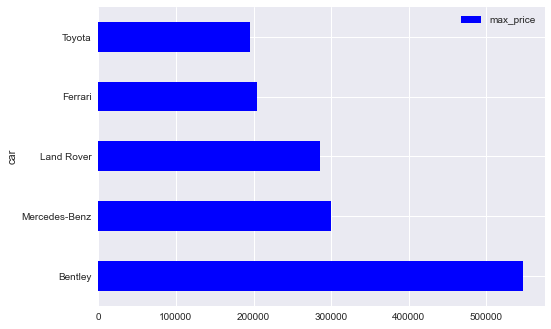

In [41]:
cars_with_max_price_df.sort_values('max_price', ascending=False).head(5).plot.barh(color='b')

In [42]:
df = cars_with_max_price_df.sort_values('max_price', ascending=False).reset_index()

In [43]:
df.car.head()

0          Bentley
1    Mercedes-Benz
2       Land Rover
3          Ferrari
4           Toyota
Name: car, dtype: object

In [44]:
carsales_df[(carsales_df.car.isin(df.car.head())) & carsales_df.price.isin(df.max_price.head())].car.value_counts()

Mercedes-Benz    3
Toyota           1
Bentley          1
Ferrari          1
Land Rover       1
Name: car, dtype: int64

In [45]:
df.head()

,car,max_price
0,Bentley,547800.0
1,Mercedes-Benz,300000.0
2,Land Rover,285000.0
3,Ferrari,205000.0
4,Toyota,195000.0


In [46]:
carsales_df[(carsales_df.car == 'Bentley') & (carsales_df.price == 547800.0)].car.value_counts()

Bentley    1
Name: car, dtype: int64

In [47]:
def get_maxPriceCarSales(r):
    return carsales_df[(carsales_df.car == r.car) & (carsales_df.price == r.max_price)].car.count()



In [48]:
df['sales'] = df.apply(get_maxPriceCarSales, axis=1)
#df.apply(get_maxPriceCarSales, axis=0)

In [49]:
df

,car,max_price,sales
0,Bentley,547800.00,1
1,Mercedes-Benz,300000.00,2
2,Land Rover,285000.00,1
3,Ferrari,205000.00,1
4,Toyota,195000.00,1
...,...,...,...
82,Buick,3500.00,1
83,Lancia,3000.00,1
84,SMA,2900.00,1
85,Moskvich-Izh,1519.05,1


In [50]:
carsales_df

,car,price,body,mileage,engV,engType,registration,year,model,drive
0,Ford,15500.0,crossover,68.0,2.50,Gas,yes,2010,Kuga,full
1,Mercedes-Benz,20500.0,sedan,173.0,1.80,Gas,yes,2011,E-Class,rear
2,Mercedes-Benz,35000.0,other,135.0,5.50,Petrol,yes,2008,CL 550,rear
3,Mercedes-Benz,17800.0,van,162.0,1.80,Diesel,yes,2012,B 180,front
4,Mercedes-Benz,33000.0,vagon,91.0,2.57,Other,yes,2013,E-Class,rear
...,...,...,...,...,...,...,...,...,...,...
9571,Hyundai,14500.0,crossover,140.0,2.00,Gas,yes,2011,Tucson,front
9572,Volkswagen,2200.0,vagon,150.0,1.60,Petrol,yes,1986,Passat B2,front
9573,Mercedes-Benz,18500.0,crossover,180.0,3.50,Petrol,yes,2008,ML 350,full
9574,Lexus,16999.0,sedan,150.0,3.50,Gas,yes,2008,ES 350,front


price <= 10000 -- Economy
price > 10000 to < 30000 -- Luxury
price -- Premium

In [51]:
carsales_df.price.describe()

count      9463.000000
mean      15948.897726
std       23754.171644
min         259.350000
25%        5450.000000
50%        9500.000000
75%       16999.000000
max      547800.000000
Name: price, dtype: float64

In [52]:
def classify_class(r):
    if r.price <= 10000:
        return "Economy"
    elif (r.price > 10000) & (r.price <= 30000):
        return "Luxury"
    else:
        return "Premium"

In [53]:
carsales_df["class"] = carsales_df.apply(classify_class, axis=1)

In [54]:
carsales_df

,car,price,body,mileage,engV,engType,registration,year,model,drive,class
0,Ford,15500.0,crossover,68.0,2.50,Gas,yes,2010,Kuga,full,Luxury
1,Mercedes-Benz,20500.0,sedan,173.0,1.80,Gas,yes,2011,E-Class,rear,Luxury
2,Mercedes-Benz,35000.0,other,135.0,5.50,Petrol,yes,2008,CL 550,rear,Premium
3,Mercedes-Benz,17800.0,van,162.0,1.80,Diesel,yes,2012,B 180,front,Luxury
4,Mercedes-Benz,33000.0,vagon,91.0,2.57,Other,yes,2013,E-Class,rear,Premium
...,...,...,...,...,...,...,...,...,...,...,...
9571,Hyundai,14500.0,crossover,140.0,2.00,Gas,yes,2011,Tucson,front,Luxury
9572,Volkswagen,2200.0,vagon,150.0,1.60,Petrol,yes,1986,Passat B2,front,Economy
9573,Mercedes-Benz,18500.0,crossover,180.0,3.50,Petrol,yes,2008,ML 350,full,Luxury
9574,Lexus,16999.0,sedan,150.0,3.50,Gas,yes,2008,ES 350,front,Luxury


In [55]:
carsales_df["class"].value_counts()

Economy    5019
Luxury     3397
Premium    1047
Name: class, dtype: int64

<AxesSubplot:>

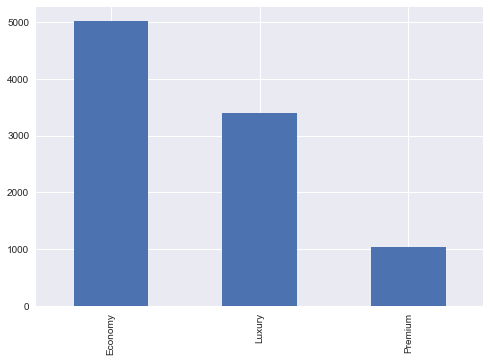

In [56]:
carsales_df["class"].value_counts().plot.bar()

In [57]:
carsales_df.pivot_table(index=['car','year'], columns="class")

engV                mileage                    price           \
class      Economy Luxury Premium Economy  Luxury Premium  Economy   Luxury   
car   year                                                                    
Acura 2005    3.20   3.50     NaN  144.75  199.00     NaN  8662.00  11111.0   
      2006     NaN   3.50     NaN     NaN  126.00     NaN      NaN  12900.0   
      2008     NaN   3.65     NaN     NaN  121.75     NaN      NaN  16587.5   
      2010     NaN    NaN     3.7     NaN     NaN    32.0      NaN      NaN   
      2014     NaN    NaN     3.5     NaN     NaN    30.0      NaN      NaN   
...            ...    ...     ...     ...     ...     ...      ...      ...   
ËUAZ  1987    1.20    NaN     NaN   31.00     NaN     NaN  1500.00      NaN   
      1990    1.20    NaN     NaN   30.00     NaN     NaN  1296.75      NaN   
      1991    1.35    NaN     NaN   68.50     NaN     NaN  1350.00      NaN   
      1994    1.20    NaN     NaN   37.00     NaN     NaN  3500.00      NaN   
      2004    1.70    NaN     NaN    2.00     NaN     NaN  5950.00      NaN   

                     
class       Premium  
car   year           
Acura 2005      NaN  
      2006      NaN  
      2008      NaN  
      2010  30999.0  
      2014  46999.0  
...             ...  
ËUAZ  1987      NaN  
      1990      NaN  
      1991      NaN  
      1994      NaN  
      2004      NaN  

[1016 rows x 9 columns]

In [58]:
pvt_caryear_sales = carsales_df.pivot_table(index=['car','year'], columns="class", values="model", aggfunc='count')

In [59]:
pvt_caryear_sales

class       Economy  Luxury  Premium
car   year                          
Acura 2005      4.0     1.0      NaN
      2006      NaN     1.0      NaN
      2008      NaN     4.0      NaN
      2010      NaN     NaN      1.0
      2014      NaN     NaN      1.0
...             ...     ...      ...
ËUAZ  1987      1.0     NaN      NaN
      1990      1.0     NaN      NaN
      1991      2.0     NaN      NaN
      1994      1.0     NaN      NaN
      2004      1.0     NaN      NaN

[1016 rows x 3 columns]

In [60]:
#pvt_caryear_sales[pvt_caryear_sales.car == "Acura"] # we cant do it

In [61]:
pvt_caryear_sales.index

MultiIndex([(     'Acura', 2005),
            (     'Acura', 2006),
            (     'Acura', 2008),
            (     'Acura', 2010),
            (     'Acura', 2014),
            (     'Acura', 2015),
            ('Alfa Romeo', 1991),
            ('Alfa Romeo', 2000),
            ('Alfa Romeo', 2002),
            ('Alfa Romeo', 2003),
            ...
            (       'ZAZ', 2012),
            (       'ZAZ', 2013),
            (       'ZAZ', 2014),
            (       'ZAZ', 2015),
            (        'ZX', 2006),
            (      'ËUAZ', 1987),
            (      'ËUAZ', 1990),
            (      'ËUAZ', 1991),
            (      'ËUAZ', 1994),
            (      'ËUAZ', 2004)],
           names=['car', 'year'], length=1016)

In [62]:
pvt_caryear_sales.index.get_level_values(0)

Index(['Acura', 'Acura', 'Acura', 'Acura', 'Acura', 'Acura', 'Alfa Romeo',
       'Alfa Romeo', 'Alfa Romeo', 'Alfa Romeo',
       ...
       'ZAZ', 'ZAZ', 'ZAZ', 'ZAZ', 'ZX', 'ËUAZ', 'ËUAZ', 'ËUAZ', 'ËUAZ',
       'ËUAZ'],
      dtype='object', name='car', length=1016)

In [63]:
pvt_caryear_sales.index.get_level_values(1)

Int64Index([2005, 2006, 2008, 2010, 2014, 2015, 1991, 2000, 2002, 2003,
            ...
            2012, 2013, 2014, 2015, 2006, 1987, 1990, 1991, 1994, 2004],
           dtype='int64', name='year', length=1016)

In [64]:
pvt_caryear_sales[pvt_caryear_sales.index.get_level_values(0) == "Acura"].fillna(0)

class       Economy  Luxury  Premium
car   year                          
Acura 2005      4.0     1.0      0.0
      2006      0.0     1.0      0.0
      2008      0.0     4.0      0.0
      2010      0.0     0.0      1.0
      2014      0.0     0.0      1.0
      2015      0.0     0.0      1.0

<AxesSubplot:xlabel='car,year'>

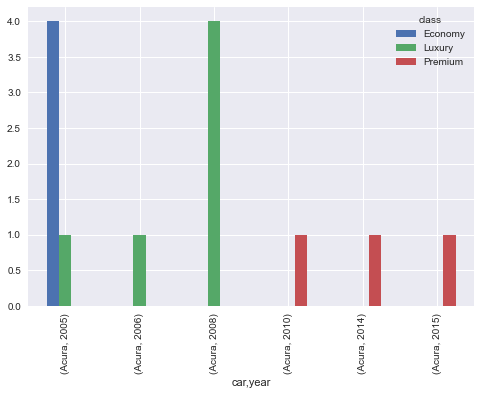

In [65]:
pvt_caryear_sales[pvt_caryear_sales.index.get_level_values(0) == "Acura"].fillna(0).plot.bar()

<AxesSubplot:xlabel='car,year'>

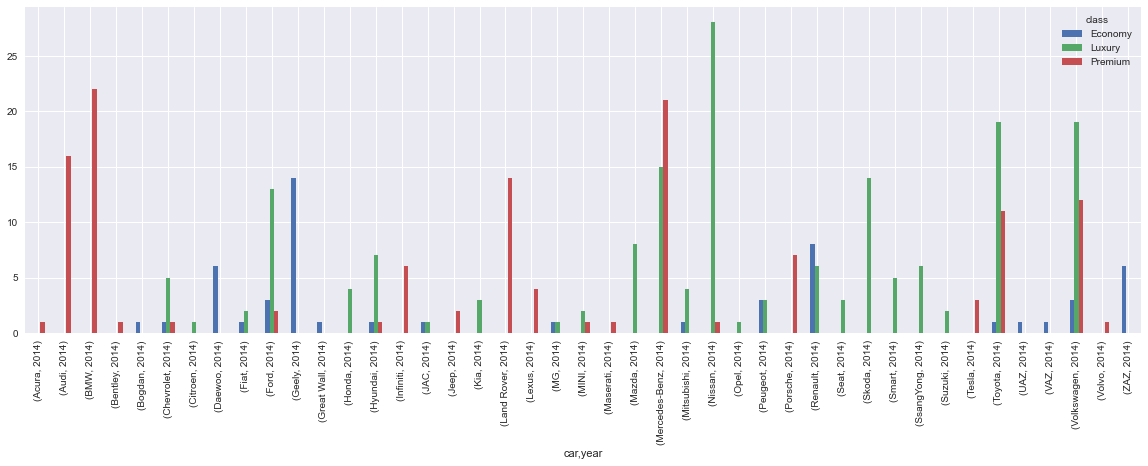

In [66]:
pvt_caryear_sales[pvt_caryear_sales.index.get_level_values(1) == 2014].fillna(0).plot.bar(figsize=(20,6))

In [67]:
pvt_caryear_revenue = carsales_df.pivot_table(index=['car','year'], columns="class", values="price", aggfunc='sum')

In [68]:
pvt_caryear_revenue

class        Economy   Luxury  Premium
car   year                            
Acura 2005  34648.00  11111.0      NaN
      2006       NaN  12900.0      NaN
      2008       NaN  66350.0      NaN
      2010       NaN      NaN  30999.0
      2014       NaN      NaN  46999.0
...              ...      ...      ...
ËUAZ  1987   1500.00      NaN      NaN
      1990   1296.75      NaN      NaN
      1991   2700.00      NaN      NaN
      1994   3500.00      NaN      NaN
      2004   5950.00      NaN      NaN

[1016 rows x 3 columns]

# Based on class - sales count

In [69]:
pvt_classyear_sales = carsales_df.pivot_table(index=['year','class'],  values="car", aggfunc='count')

In [70]:
pvt_classyear_sales

car
year class       
1953 Luxury     1
1958 Economy    1
1959 Economy    1
1961 Economy    2
1962 Economy    1
...           ...
2015 Luxury   114
     Premium  103
2016 Economy    5
     Luxury   149
     Premium  261

[100 rows x 1 columns]

<AxesSubplot:xlabel='year,class'>

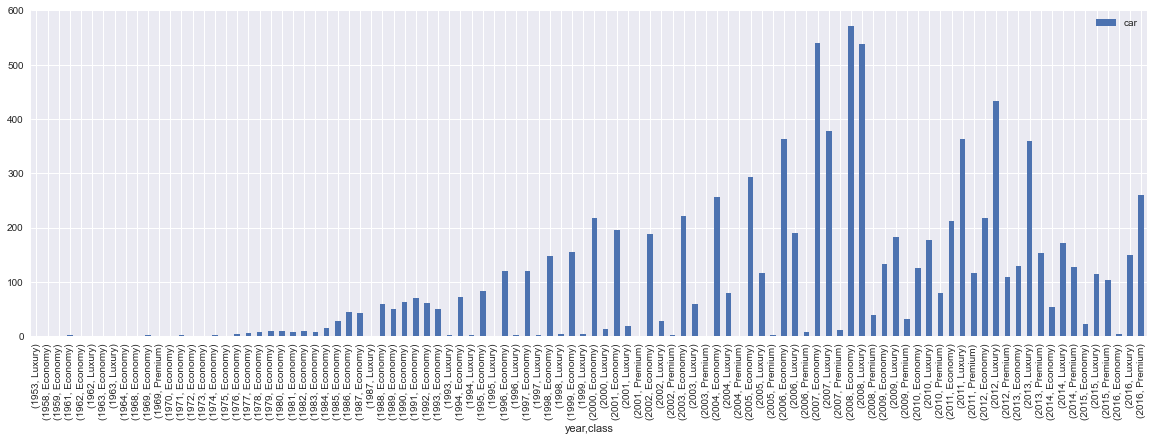

In [71]:
pvt_classyear_sales.plot.bar(figsize=(20,6))


<AxesSubplot:xlabel='year,class'>

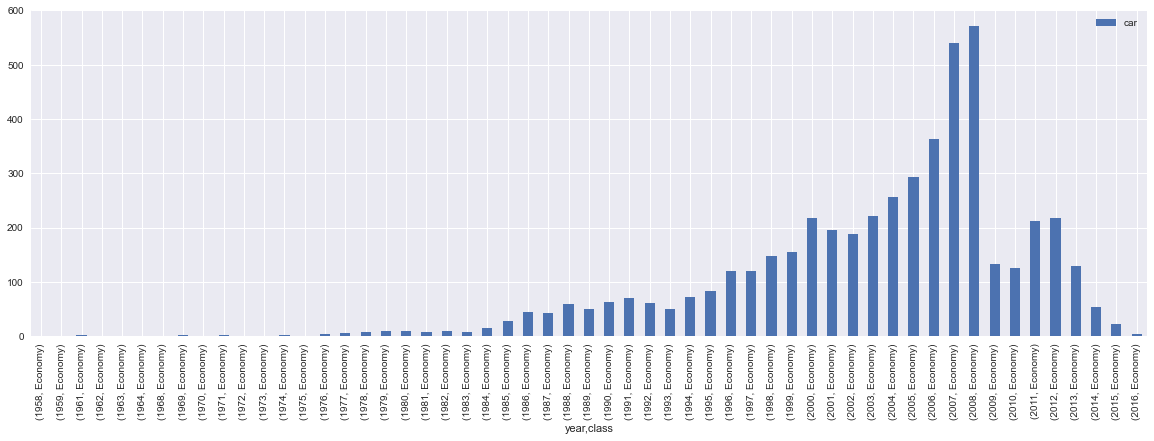

In [72]:
pvt_classyear_sales[pvt_classyear_sales.index.get_level_values(1) == "Economy"].plot.bar(figsize=(20,6))

<AxesSubplot:xlabel='year,class'>

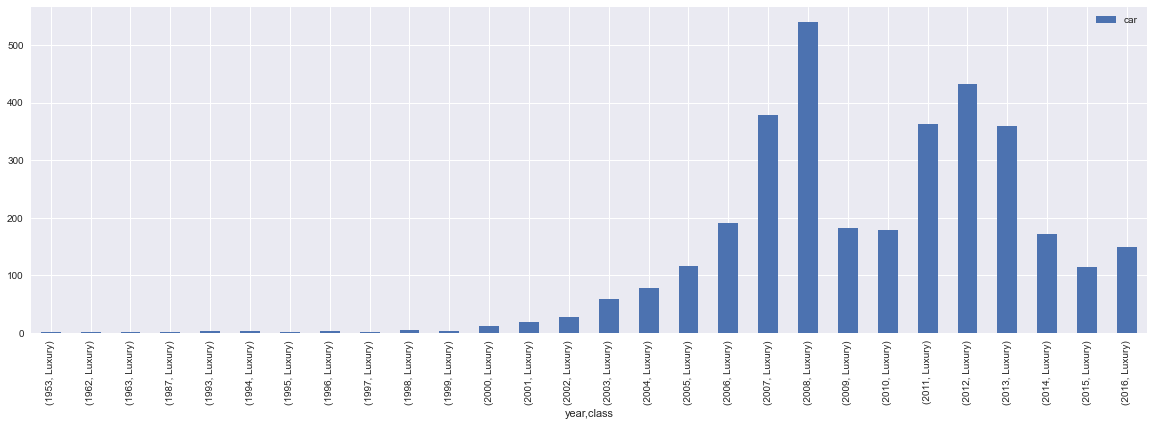

In [73]:
pvt_classyear_sales[pvt_classyear_sales.index.get_level_values(1) == "Luxury"].plot.bar(figsize=(20,6))

<AxesSubplot:xlabel='year,class'>

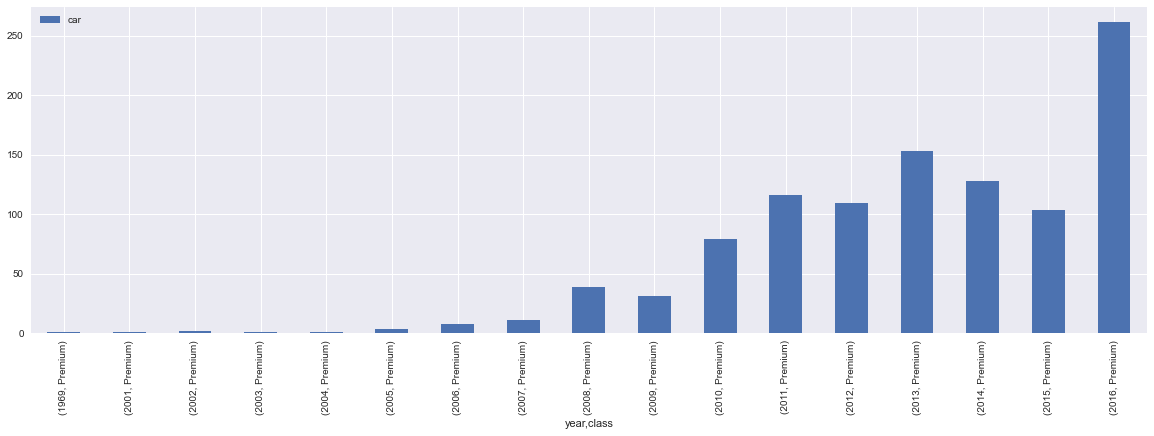

In [74]:
pvt_classyear_sales[pvt_classyear_sales.index.get_level_values(1) == "Premium"].plot.bar(figsize=(20,6))

In [75]:
#pvt_classyear_sales.fillna(0).plot.scatter(x=pvt_classyear_sales.car.fillna(0), y=pvt_classyear_sales.index.get_level_values(0))

In [76]:
pvt_classyear_sales.index.get_level_values(0)

Int64Index([1953, 1958, 1959, 1961, 1962, 1962, 1963, 1963, 1964, 1968, 1969,
            1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
            1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1987, 1988, 1989,
            1990, 1991, 1992, 1993, 1993, 1994, 1994, 1995, 1995, 1996, 1996,
            1997, 1997, 1998, 1998, 1999, 1999, 2000, 2000, 2001, 2001, 2001,
            2002, 2002, 2002, 2003, 2003, 2003, 2004, 2004, 2004, 2005, 2005,
            2005, 2006, 2006, 2006, 2007, 2007, 2007, 2008, 2008, 2008, 2009,
            2009, 2009, 2010, 2010, 2010, 2011, 2011, 2011, 2012, 2012, 2012,
            2013, 2013, 2013, 2014, 2014, 2014, 2015, 2015, 2015, 2016, 2016,
            2016],
           dtype='int64', name='year')

In [77]:
pvt_classyear_sales.index.names[0]

'year'

In [78]:
pvt_classyear_sales.reset_index()


,year,class,car
0,1953,Luxury,1
1,1958,Economy,1
2,1959,Economy,1
3,1961,Economy,2
4,1962,Economy,1
...,...,...,...
95,2015,Luxury,114
96,2015,Premium,103
97,2016,Economy,5
98,2016,Luxury,149


In [79]:
pvt_classyear_sales.rename(columns={"car":"car_sales"}, inplace=True)

In [80]:
pvt_classyear_sales.reset_index(inplace=True)

In [81]:
pvt_classyear_sales

,year,class,car_sales
0,1953,Luxury,1
1,1958,Economy,1
2,1959,Economy,1
3,1961,Economy,2
4,1962,Economy,1
...,...,...,...
95,2015,Luxury,114
96,2015,Premium,103
97,2016,Economy,5
98,2016,Luxury,149


In [82]:
year = pvt_classyear_sales.year
car_class = pvt_classyear_sales['class']
car_sales = pvt_classyear_sales.car_sales

Text(0, 0.5, 'Sales')

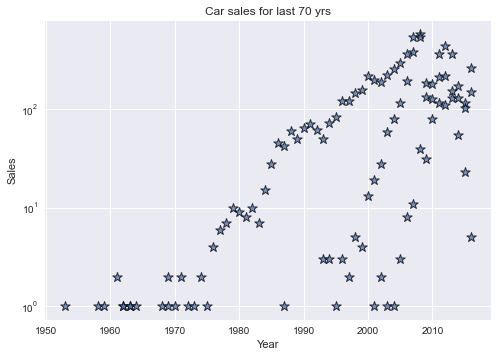

In [83]:
plt.scatter(year, car_sales, edgecolor='black', s=100, linewidth=1, alpha=0.75, marker='*')
#plt.xscale('log')
plt.yscale('log')

plt.title('Car sales for last 70 yrs')
plt.xlabel('Year')
plt.ylabel('Sales')

In [84]:
#pvt_classyear_sales

In [85]:
def get_sales_by_class(cls):
    return pvt_classyear_sales[pvt_classyear_sales['class'] == cls]

In [86]:
get_sales_by_class('Economy').head()

,year,class,car_sales
1,1958,Economy,1
2,1959,Economy,1
3,1961,Economy,2
4,1962,Economy,1
6,1963,Economy,1


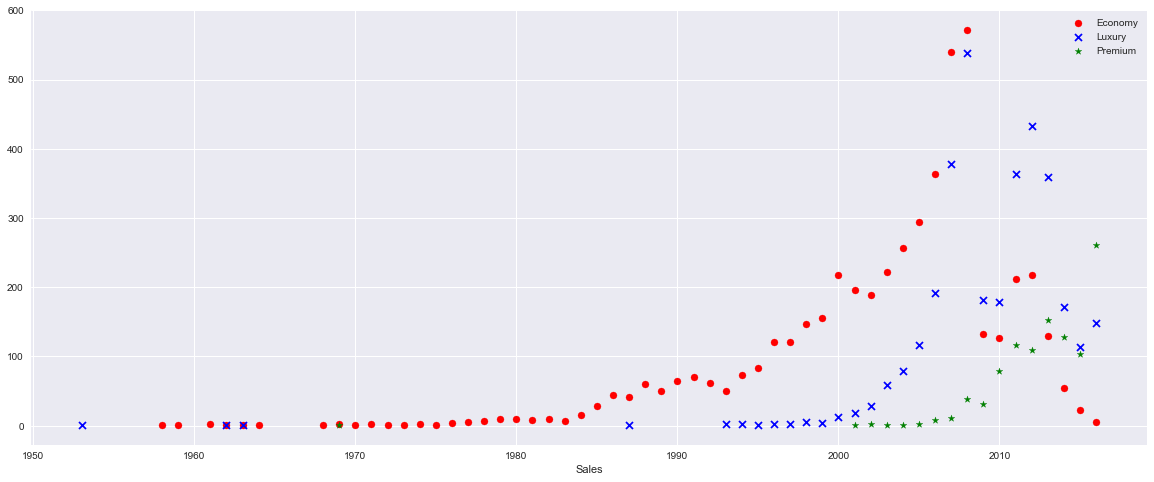

In [87]:
economy_sales = get_sales_by_class('Economy')
luxury_sales = get_sales_by_class('Luxury')
premium_sales = get_sales_by_class('Premium')

plt.figure(figsize=(20, 8))
plt.scatter(economy_sales.year, economy_sales.car_sales, color="r", label="Economy")
plt.scatter(luxury_sales.year, luxury_sales.car_sales, color="b", label="Luxury", marker='x')
plt.scatter(premium_sales.year, premium_sales.car_sales, color="g", label="Premium", marker='*')
plt.xlabel('Year')
plt.xlabel('Sales')
plt.legend()


<BarContainer object of 17 artists>

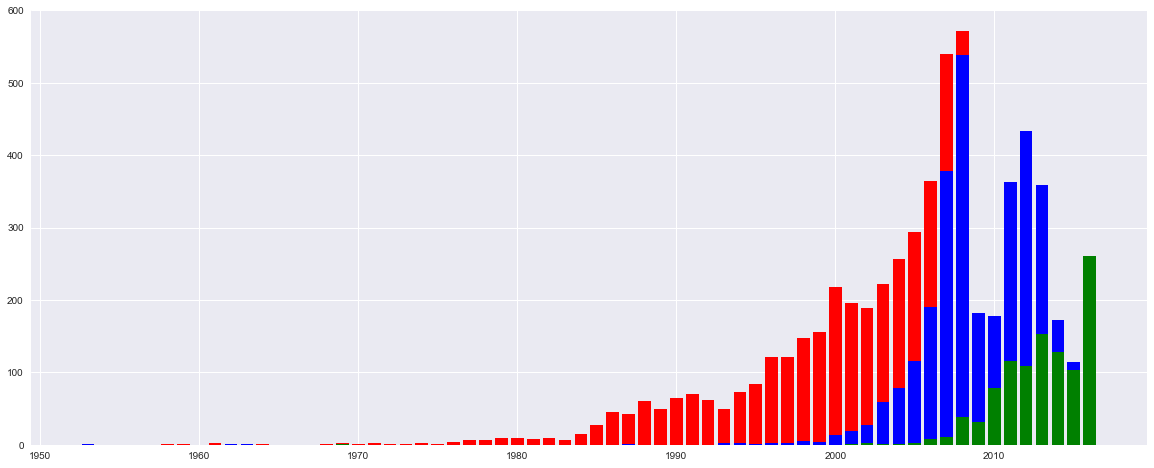

In [88]:
plt.figure(figsize=(20, 8))
plt.bar(economy_sales.year, economy_sales.car_sales, color="r")
plt.bar(luxury_sales.year, luxury_sales.car_sales, color="b")
plt.bar(premium_sales.year, premium_sales.car_sales, color="g")


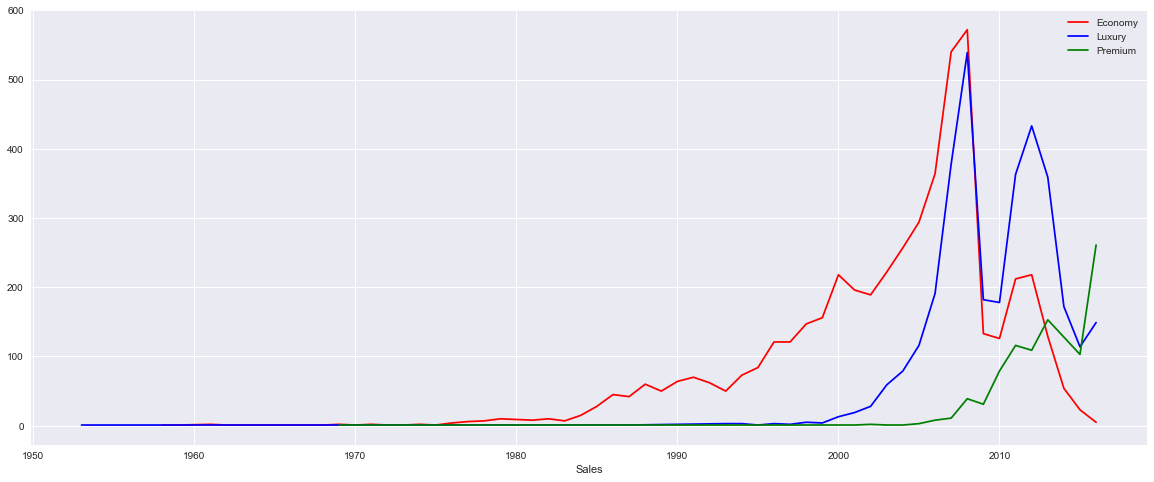

In [89]:
plt.figure(figsize=(20, 8))
plt.plot(economy_sales.year, economy_sales.car_sales, color="r", label="Economy")
plt.plot(luxury_sales.year, luxury_sales.car_sales, color="b", label="Luxury")
plt.plot(premium_sales.year, premium_sales.car_sales, color="g", label="Premium")
plt.xlabel('Year')
plt.xlabel('Sales')
plt.legend()

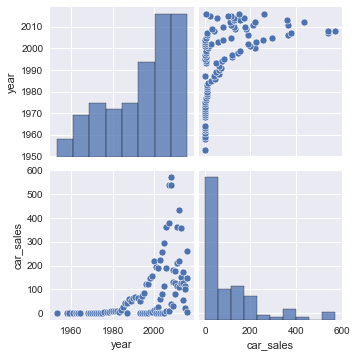

In [90]:
sns.pairplot(pvt_classyear_sales)

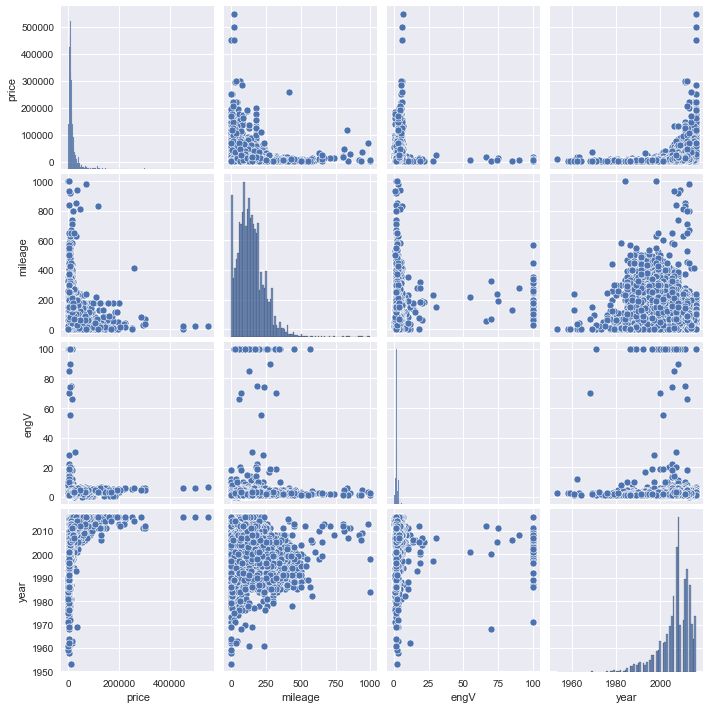

In [91]:
sns.pairplot(carsales_df)

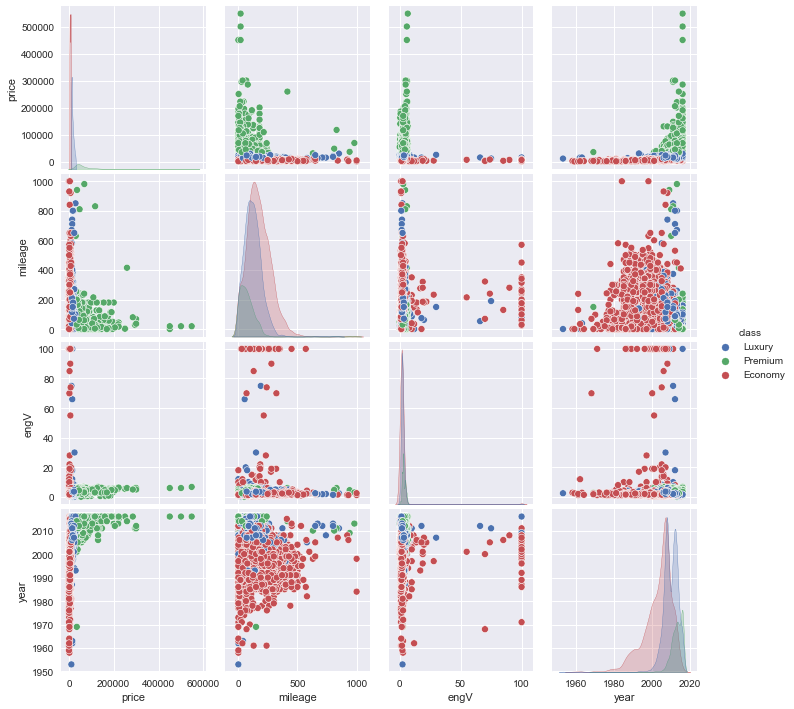

In [92]:
sns.pairplot(carsales_df, hue="class")

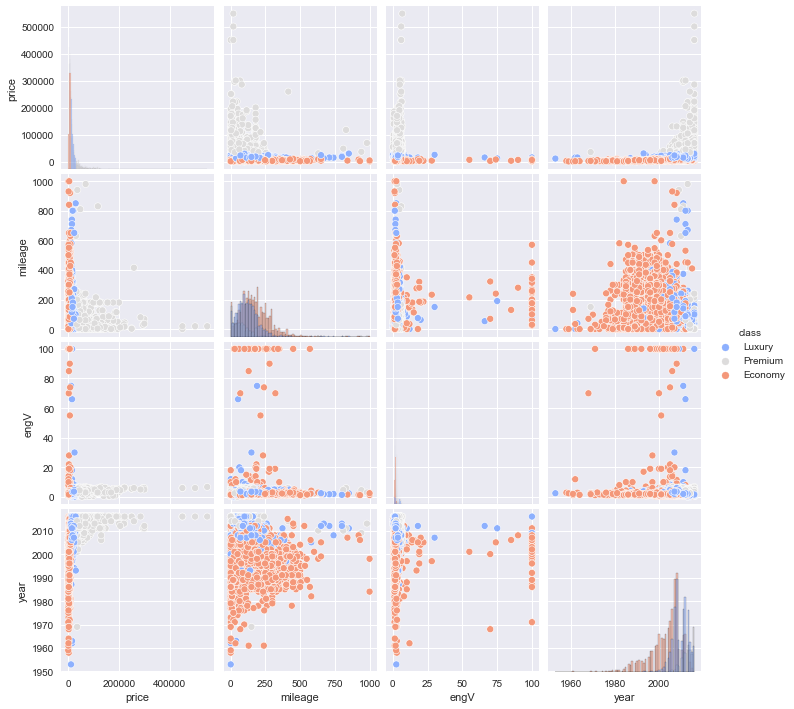

In [93]:
sns.pairplot(carsales_df, hue="class", diag_kind="hist",palette ='coolwarm')

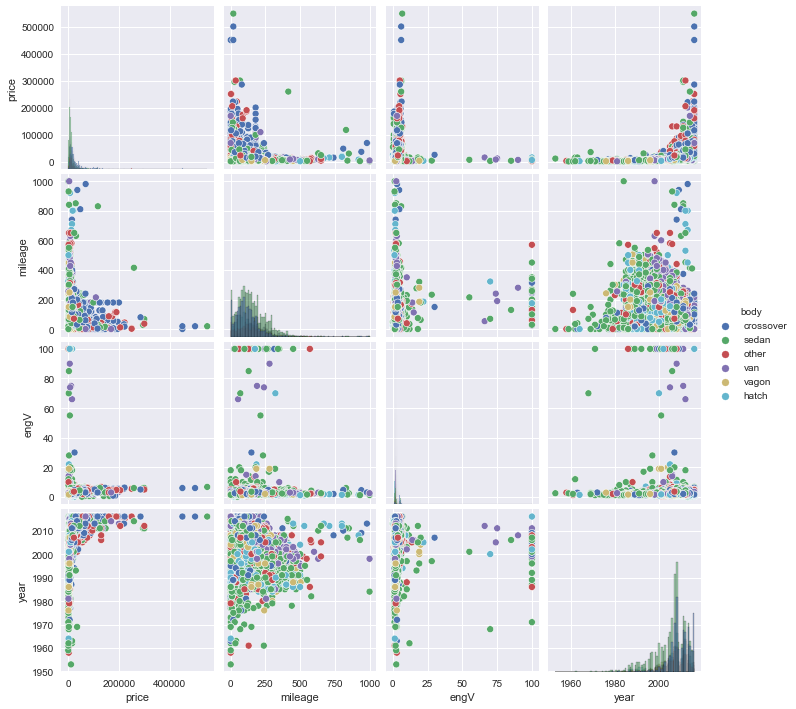

In [94]:
sns.pairplot(carsales_df, hue="body", diag_kind="hist")

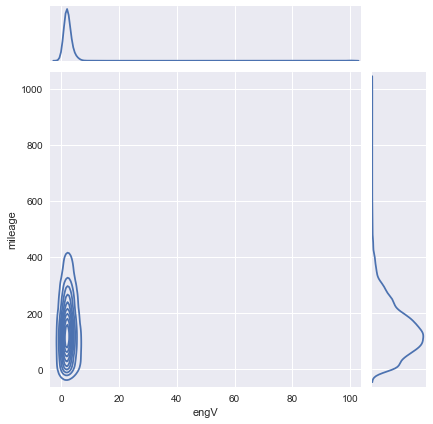

In [95]:
sns.jointplot(x ='engV', y ='mileage', data = carsales_df, kind ='kde') 

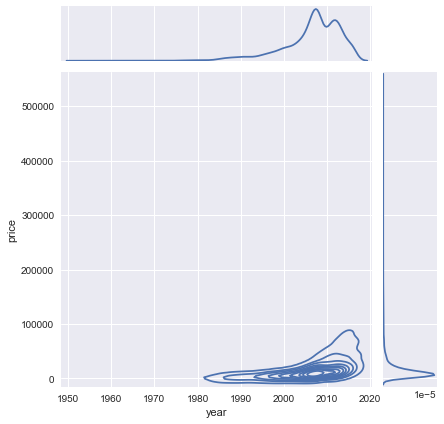

In [96]:
sns.jointplot(x ='year', y ='price', data = carsales_df, kind ='kde') 

D:\ProgramData\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mileage', ylabel='Density'>

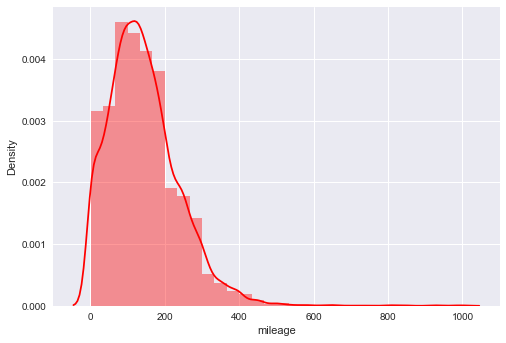

In [97]:
sns.distplot(carsales_df['mileage'], kde = True, color ='red', bins = 30) 

# Carsales Trend by Body Type

In [98]:

pvt_bodyyear_sales = carsales_df.pivot_table(index=['year','body'],  values="car", aggfunc='count')
pvt_bodyyear_sales.rename(columns={"car":"car_sales"}, inplace=True)
pvt_bodyyear_sales.reset_index(inplace=True)

def get_sales_by_body(body):
    return pvt_bodyyear_sales[pvt_bodyyear_sales['body'] == body]



# crossover
# sedan
# van
# vagon
# hatch
# other




In [99]:
pvt_bodyyear_sales

,year,body,car_sales
0,1953,sedan,1
1,1958,other,1
2,1959,sedan,1
3,1961,other,1
4,1961,sedan,1
...,...,...,...
230,2016,hatch,27
231,2016,other,39
232,2016,sedan,85
233,2016,vagon,11


In [100]:

pvt_bodyyear_revenue = carsales_df.pivot_table(index=['year','body'],  values="price", aggfunc='sum')
pvt_bodyyear_revenue.rename(columns={"price":"revenue"}, inplace=True)
pvt_bodyyear_revenue.reset_index(inplace=True)

def get_revenue_by_body(body):
    return pvt_bodyyear_revenue[pvt_bodyyear_revenue['body'] == body]

In [101]:
get_sales_by_body("crossover")

,year,body,car_sales
6,1963,crossover,1
13,1972,crossover,1
17,1976,crossover,1
20,1977,crossover,1
22,1978,crossover,1
24,1979,crossover,2
27,1980,crossover,1
31,1981,crossover,2
36,1982,crossover,2
42,1984,crossover,1


In [102]:
pvt_bodyyear_sales

,year,body,car_sales
0,1953,sedan,1
1,1958,other,1
2,1959,sedan,1
3,1961,other,1
4,1961,sedan,1
...,...,...,...
230,2016,hatch,27
231,2016,other,39
232,2016,sedan,85
233,2016,vagon,11


In [103]:
pd.set_option('display.float_format', '{:.0f}'.format)
pvt_bodyyear_revenue

,year,body,revenue
0,1953,sedan,11000
1,1958,other,2100
2,1959,sedan,259
3,1961,other,4000
4,1961,sedan,500
...,...,...,...
230,2016,hatch,556593
231,2016,other,2966803
232,2016,sedan,3558696
233,2016,vagon,221307


In [104]:
get_sales_by_body('van')

,year,body,car_sales
35,1981,van,1
51,1985,van,2
66,1988,van,3
72,1989,van,2
78,1990,van,1
84,1991,van,1
90,1992,van,3
96,1993,van,3
102,1994,van,3
108,1995,van,6


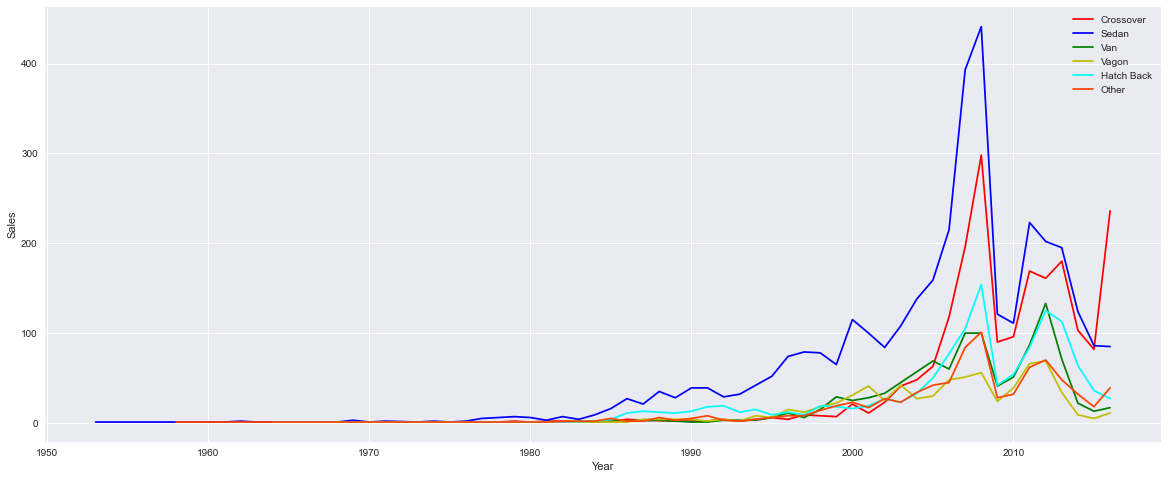

In [105]:
crossover_sales = get_sales_by_body('crossover')
sedan_sales = get_sales_by_body('sedan')
van_sales = get_sales_by_body('van')
vagon_sales = get_sales_by_body('vagon')
hatch_sales = get_sales_by_body('hatch')
other_sales = get_sales_by_body('other')

plt.figure(figsize=(20, 8))
plt.plot(crossover_sales.year, crossover_sales.car_sales, color="r", label="Crossover")
plt.plot(sedan_sales.year, sedan_sales.car_sales, color="b", label="Sedan")
plt.plot(van_sales.year, van_sales.car_sales, color="g", label="Van")
plt.plot(vagon_sales.year, vagon_sales.car_sales, color="y", label="Vagon")
plt.plot(hatch_sales.year, hatch_sales.car_sales, color="aqua", label="Hatch Back")
plt.plot(other_sales.year, other_sales.car_sales, color="orangered", label="Other")

plt.xlabel('Year')
plt.ylabel('Sales')
plt.legend()

In [106]:
carsales_df[carsales_df.body == 'hatch']['class'].value_counts()

Economy    914
Luxury     316
Premium     18
Name: class, dtype: int64

In [107]:
revenue_body_df = carsales_df.pivot_table(index=['body'],  values=['price'], aggfunc=['sum','count'])

In [108]:
revenue_body_df

,sum,count
,price,price
body,,
crossover,61851772,2007
hatch,10588161,1248
other,16170376,829
sedan,44702711,3622
vagon,6409851,719
van,11201548,1038


In [109]:
revenue_body_df.columns

MultiIndex([(  'sum', 'price'),
            ('count', 'price')],
           )

In [110]:
revenue_body_df.reset_index( inplace=True)

In [111]:
revenue_body_df

,body,sum,count
,,price,price
0,crossover,61851772,2007
1,hatch,10588161,1248
2,other,16170376,829
3,sedan,44702711,3622
4,vagon,6409851,719
5,van,11201548,1038


In [112]:
revenue_body_df.columns

MultiIndex([( 'body',      ''),
            (  'sum', 'price'),
            ('count', 'price')],
           )

In [113]:
revenue_body_df.rename(columns={('sum', 'price'):('revenue', ''), ('count', 'price'):('car_sales', '')}, inplace=True)

In [114]:
revenue_body_df#.shape

,body,sum,count
,,price,price
0,crossover,61851772,2007
1,hatch,10588161,1248
2,other,16170376,829
3,sedan,44702711,3622
4,vagon,6409851,719
5,van,11201548,1038


In [115]:
revenue_body_df.set_index('body', inplace=True)

In [116]:
revenue_body_df

,sum,count
,price,price
body,,
crossover,61851772,2007
hatch,10588161,1248
other,16170376,829
sedan,44702711,3622
vagon,6409851,719
van,11201548,1038


In [117]:
revenue_body_df.index


Index(['crossover', 'hatch', 'other', 'sedan', 'vagon', 'van'], dtype='object', name='body')

In [118]:
revenue_body_df.columns

MultiIndex([(  'sum', 'price'),
            ('count', 'price')],
           )

In [119]:
pvt_classyear_sales

,year,class,car_sales
0,1953,Luxury,1
1,1958,Economy,1
2,1959,Economy,1
3,1961,Economy,2
4,1962,Economy,1
...,...,...,...
95,2015,Luxury,114
96,2015,Premium,103
97,2016,Economy,5
98,2016,Luxury,149


# What is sales trend from last 5 yrs?
# which car maker has sold most cars in the last five years in each class of cars.

In [120]:

# 

carsales_5year = carsales_df[carsales_df.year.isin(pd.DataFrame(carsales_df.year.unique())[0].nlargest())].groupby('year').car.value_counts()


In [121]:
carsales_5year

year  car          
2012  Volkswagen       104
      Renault           94
      Skoda             60
      Mercedes-Benz     44
      Toyota            43
                      ... 
2016  Jaguar             1
      Jeep               1
      Opel               1
      Smart              1
      UAZ                1
Name: car, Length: 197, dtype: int64

In [122]:
pd.DataFrame(carsales_df.year.unique())[0].nlargest()

6     2016
11    2015
10    2014
4     2013
3     2012
Name: 0, dtype: int64

<AxesSubplot:xlabel='year,car'>

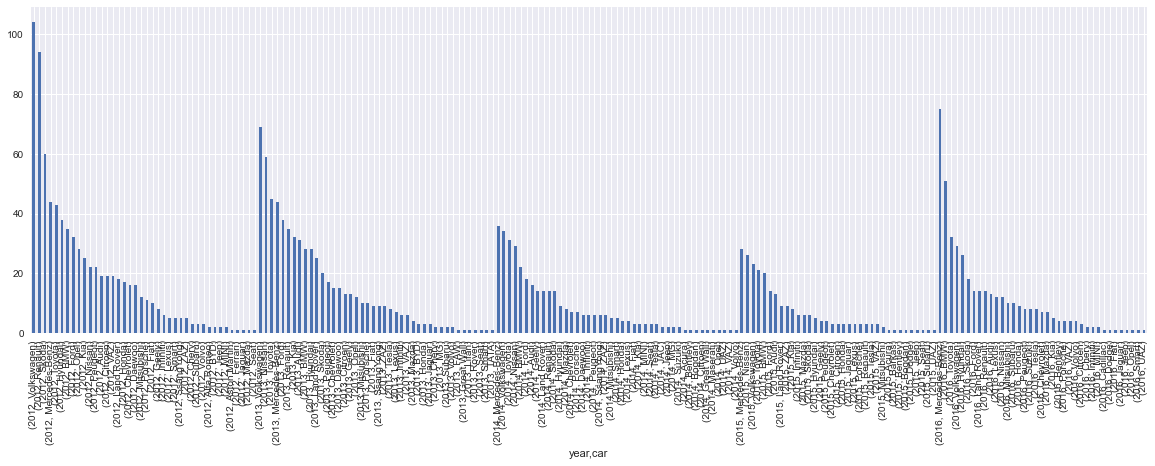

In [123]:
carsales_5year.plot.bar(figsize=(20,6))

In [124]:
classsales_5year = carsales_df[carsales_df.year.isin(pd.DataFrame(carsales_df.year.unique())[0].nlargest())].groupby('year')['class'].value_counts()


In [125]:
classsales_5year

year  class  
2012  Luxury     433
      Economy    218
      Premium    109
2013  Luxury     359
      Premium    153
      Economy    129
2014  Luxury     172
      Premium    128
      Economy     54
2015  Luxury     114
      Premium    103
      Economy     23
2016  Premium    261
      Luxury     149
      Economy      5
Name: class, dtype: int64

In [126]:
sales_5yrs = pd.DataFrame(classsales_5year)

In [127]:
sales_5yrs.rename(columns= {"class":"sales"}, inplace=True)

In [128]:
sales_5yrs.reset_index(inplace=True)
sales_5yrs

,year,class,sales
0,2012,Luxury,433
1,2012,Economy,218
2,2012,Premium,109
3,2013,Luxury,359
4,2013,Premium,153
5,2013,Economy,129
6,2014,Luxury,172
7,2014,Premium,128
8,2014,Economy,54
9,2015,Luxury,114


In [129]:
# Carsales for last 5 years by class

#sales_5yrs[sales_5yrs['class'] == 'Premium']

def get_SalesByClass(cls):
    return sales_5yrs[sales_5yrs['class'] == cls]

In [130]:
get_SalesByClass('Premium')

,year,class,sales
2,2012,Premium,109
4,2013,Premium,153
7,2014,Premium,128
10,2015,Premium,103
12,2016,Premium,261


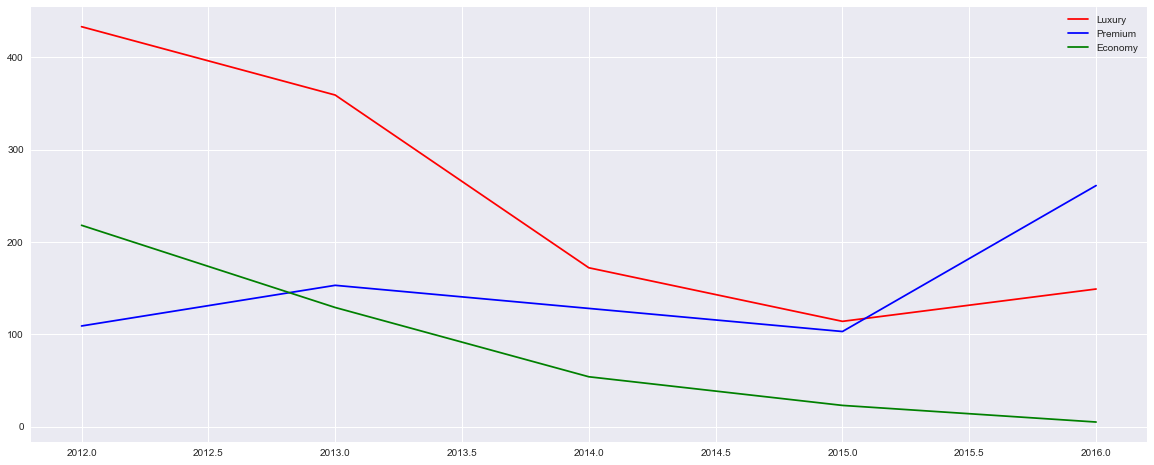

In [131]:
df_luxury = get_SalesByClass('Luxury')
df_premium = get_SalesByClass('Premium')
df_economy = get_SalesByClass('Economy')

bins = df_luxury.year
plt.figure(figsize=(20, 8))
plt.plot(df_luxury.year, df_luxury.sales, color="r", label="Luxury")
plt.plot(df_premium.year, df_premium.sales, color="b", label="Premium")
plt.plot(df_economy.year, df_economy.sales, color="g", label="Economy")
plt.legend()

In [132]:
df_luxury.year

0     2012
3     2013
6     2014
9     2015
13    2016
Name: year, dtype: int64

# What is the most selling car body type? 

In [133]:
df = carsales_df.pivot_table(index=['body'],  values="car", aggfunc='count')


In [134]:
df.reset_index(inplace=True)

In [135]:
df.rename(columns={'car':'sales'}, inplace=True)

In [136]:
df

,body,sales
0,crossover,2007
1,hatch,1248
2,other,829
3,sedan,3622
4,vagon,719
5,van,1038


<AxesSubplot:ylabel='body'>

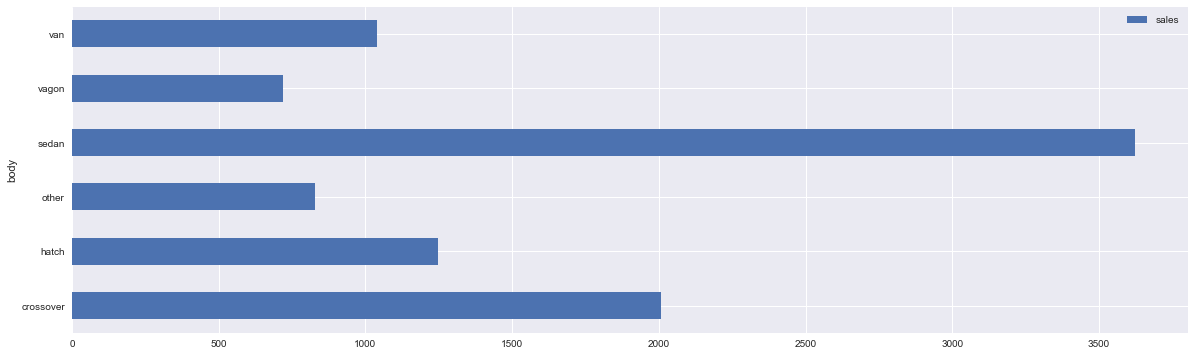

In [137]:
df.plot.barh(figsize=(20,6), x="body")

# Can we find out most preferred body type(vehicle in each class) used over the years? 

In [138]:

pvt_bodyclassyear_sales = carsales_df.pivot_table(index=['class','body'],  values="car", aggfunc='count')
pvt_bodyclassyear_sales.rename(columns={"car":"sales"}, inplace=True)
pvt_bodyclassyear_sales.reset_index(inplace=True)

#def get_revenue_by_body(body):
#    return pvt_bodyyear_revenue[pvt_bodyyear_revenue['body'] == body]

In [139]:
pvt_bodyclassyear_sales

,class,body,sales
0,Economy,crossover,262
1,Economy,hatch,914
2,Economy,other,377
3,Economy,sedan,2274
4,Economy,vagon,483
5,Economy,van,709
6,Luxury,crossover,1123
7,Luxury,hatch,316
8,Luxury,other,333
9,Luxury,sedan,1116


<AxesSubplot:ylabel='sales'>

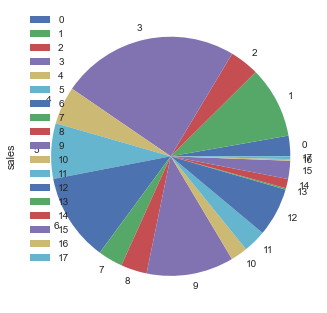

In [140]:
pvt_bodyclassyear_sales.plot.pie(y="sales", x="class")

# which car gives more mileage in economy class from the data in the last five years.

In [141]:
carsales_df

,car,price,body,mileage,engV,engType,registration,year,model,drive,class
0,Ford,15500,crossover,68,2,Gas,yes,2010,Kuga,full,Luxury
1,Mercedes-Benz,20500,sedan,173,2,Gas,yes,2011,E-Class,rear,Luxury
2,Mercedes-Benz,35000,other,135,6,Petrol,yes,2008,CL 550,rear,Premium
3,Mercedes-Benz,17800,van,162,2,Diesel,yes,2012,B 180,front,Luxury
4,Mercedes-Benz,33000,vagon,91,3,Other,yes,2013,E-Class,rear,Premium
...,...,...,...,...,...,...,...,...,...,...,...
9571,Hyundai,14500,crossover,140,2,Gas,yes,2011,Tucson,front,Luxury
9572,Volkswagen,2200,vagon,150,2,Petrol,yes,1986,Passat B2,front,Economy
9573,Mercedes-Benz,18500,crossover,180,4,Petrol,yes,2008,ML 350,full,Luxury
9574,Lexus,16999,sedan,150,4,Gas,yes,2008,ES 350,front,Luxury


In [142]:
besteconomycars = pd.DataFrame(carsales_df.groupby(['car', 'class']).mileage)

In [143]:
besteconomycars = carsales_df.pivot_table(index=['class','car'],  values="mileage", aggfunc='max')

In [144]:
besteconomycars.reset_index(inplace=True)

In [145]:
besteconomycars

,class,car,mileage
0,Economy,Acura,145
1,Economy,Alfa Romeo,230
2,Economy,Aro,43
3,Economy,Audi,470
4,Economy,BMW,460
...,...,...,...
157,Premium,Subaru,134
158,Premium,Tesla,52
159,Premium,Toyota,940
160,Premium,Volkswagen,189


<AxesSubplot:xlabel='class'>

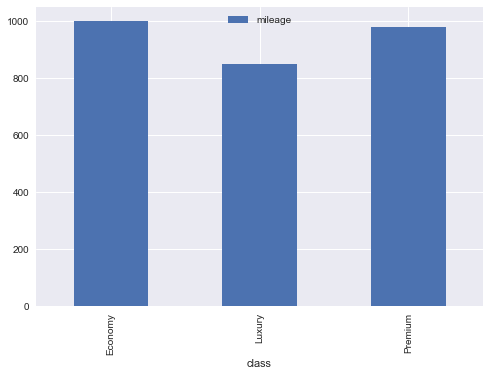

In [146]:
besteconomycars.groupby('class').max('mileage').plot.bar()

<AxesSubplot:xlabel='class'>

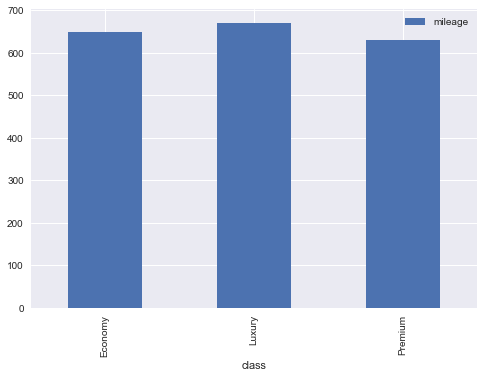

In [147]:
besteconomycars[besteconomycars.mileage < 700].groupby('class').max('mileage').plot.bar()

In [148]:
besteconomycars.describe().iloc[6].mileage   


343.5

<AxesSubplot:>

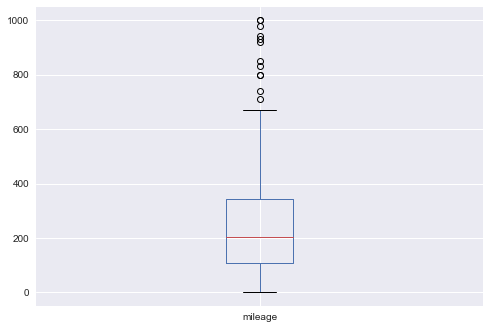

In [149]:
besteconomycars.plot.box()

<AxesSubplot:>

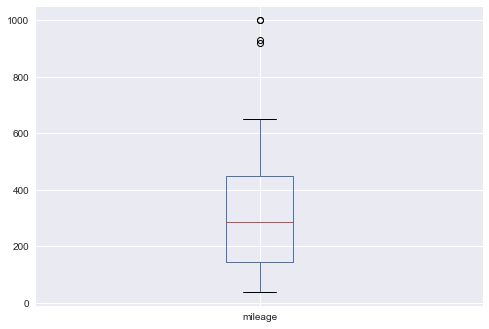

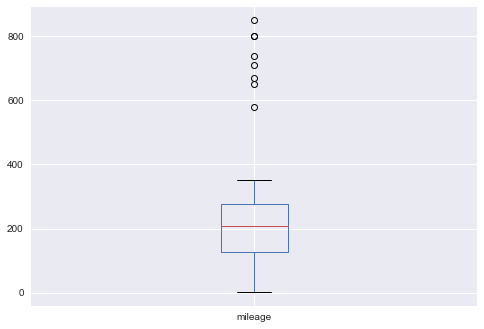

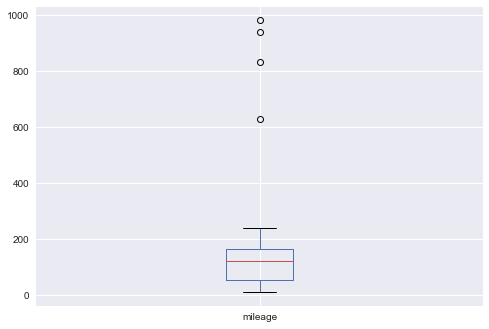

In [150]:
besteconomycars[besteconomycars['class'] == 'Economy'].plot.box(subplots=True)
besteconomycars[besteconomycars['class'] == 'Luxury'].plot.box()
besteconomycars[besteconomycars['class'] == 'Premium'].plot.box()

Text(0.5, 1.0, 'Mileage vs Class')

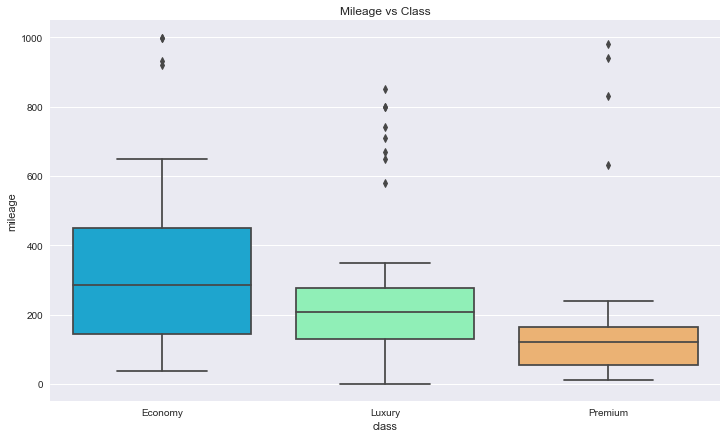

In [151]:
plt.figure(figsize=(12,7))
sns.boxplot(data=besteconomycars, x='class', y='mileage', palette='rainbow')

plt.title('Mileage vs Class')

In [152]:
# Return upper whisker for mileage by class
def get_best_carandmileage_byclass(cls):
    clsmileage = besteconomycars[besteconomycars['class'] == cls]
    maxval = clsmileage.mileage.max()
    thirdQurtile = clsmileage.describe().iloc[6].mileage   
    firstQurtile = clsmileage.describe().iloc[4].mileage     
    iqr = thirdQurtile - firstQurtile
    upperwhisker = min(maxval, thirdQurtile + (1.5 * iqr))
    return upperwhisker

# Get closest upper whisker milage results
def get_closest(cls, val):
    cls_df = carsales_df[carsales_df['class'] == cls]
    return cls_df.iloc[(cls_df['mileage']-val).abs().argsort()[:2]]

In [153]:
get_best_carandmileage_byclass('Economy')

907.5

In [154]:
get_best_carandmileage_byclass('Luxury')

498.625

In [155]:
get_best_carandmileage_byclass('Premium')

330.0

In [156]:
get_closest('Economy', get_best_carandmileage_byclass('Economy'))



,car,price,body,mileage,engV,engType,registration,year,model,drive,class
4572,Kia,7150,hatch,920,1,Petrol,yes,2008,Ceed,front,Economy
7970,ZAZ,1600,sedan,930,1,Gas,yes,2006,1103 Ñëàâóòà,front,Economy


In [157]:
get_closest('Luxury', get_best_carandmileage_byclass('Luxury'))


,car,price,body,mileage,engV,engType,registration,year,model,drive,class
898,Volkswagen,12900,other,440,1,Petrol,yes,2008,Eos,front,Luxury
5009,Mercedes-Benz,12300,sedan,423,5,Gas,yes,1997,S 500,rear,Luxury


In [158]:
get_closest('Premium', get_best_carandmileage_byclass('Premium'))

,car,price,body,mileage,engV,engType,registration,year,model,drive,class
1033,Mercedes-Benz,32000,van,255,3,Diesel,yes,2008,Sprinter 318 ïàññ.,rear,Premium
8948,Mercedes-Benz,32500,crossover,254,3,Diesel,yes,2008,GL 320,full,Premium


# Registration of cars by Class

In [159]:
carsales_df[carsales_df.registration == 'no'].groupby('class').car.count()

class
Economy    530
Luxury      30
Premium      1
Name: car, dtype: int64

Text(0.5, 1.0, 'Registration (Premium)')

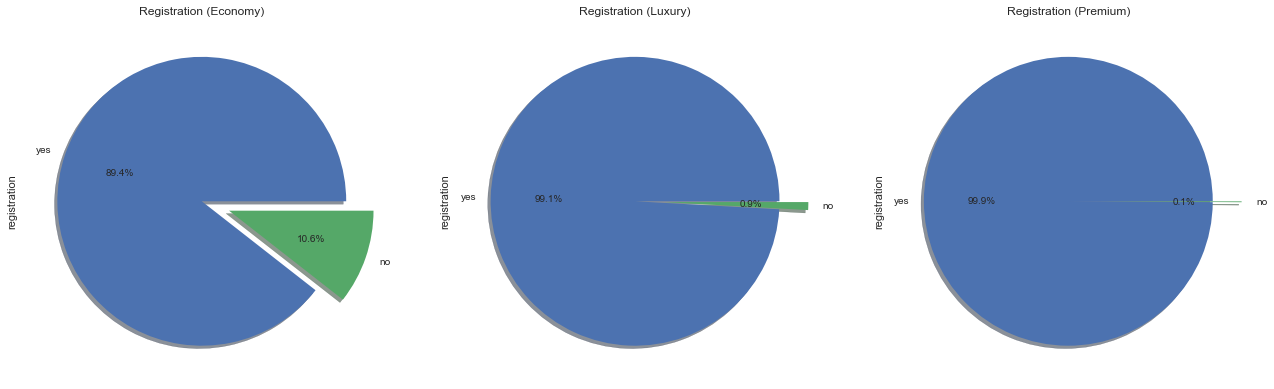

In [160]:
f,ax = plt.subplots(1,3,figsize=(22,10))
carsales_df[carsales_df['class'] == 'Economy'].registration.value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[0],shadow=True)
carsales_df[carsales_df['class'] == 'Luxury'].registration.value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[1],shadow=True)
carsales_df[carsales_df['class'] == 'Premium'].registration.value_counts().plot.pie(explode=[0,0.2],autopct='%1.1f%%',ax=ax[2],shadow=True)
ax[0].set_title('Registration (Economy)')
ax[1].set_title('Registration (Luxury)')
ax[2].set_title('Registration (Premium)')

# Problem Statement

* Last few months the sales are down.. what could be the reason?

* Sales could be dropped due to high prices.. lets check

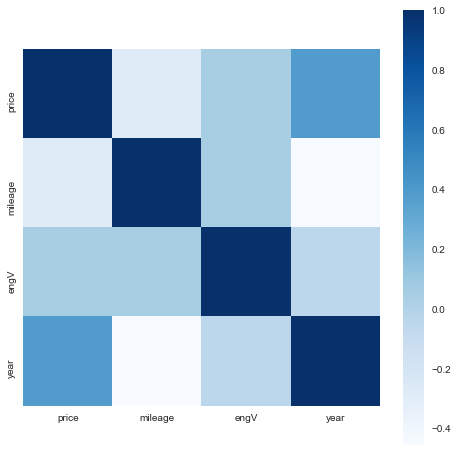

In [161]:
features_correlation = carsales_df.corr()
plt.figure(figsize=(8,8))
sns.heatmap(features_correlation,vmax=1,square=True,annot=False,cmap='Blues')
plt.show()

<AxesSubplot:xlabel='year', ylabel='price'>

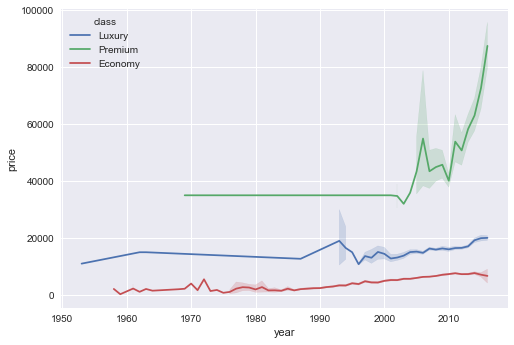

In [162]:
# Sales could be dropped due to high prices.. lets check


sns.lineplot(data=carsales_df, x='year', y='price', hue='class')

<AxesSubplot:xlabel='year', ylabel='price'>

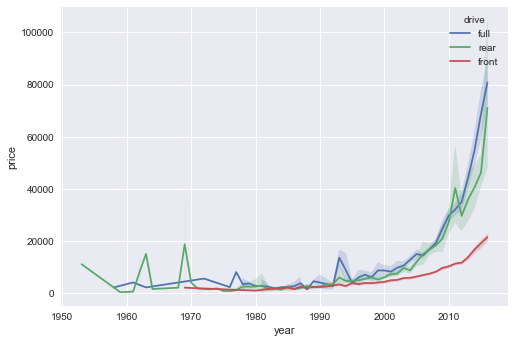

In [163]:
sns.lineplot(data=carsales_df, x='year', y='price', hue='drive')

<AxesSubplot:xlabel='year', ylabel='price'>

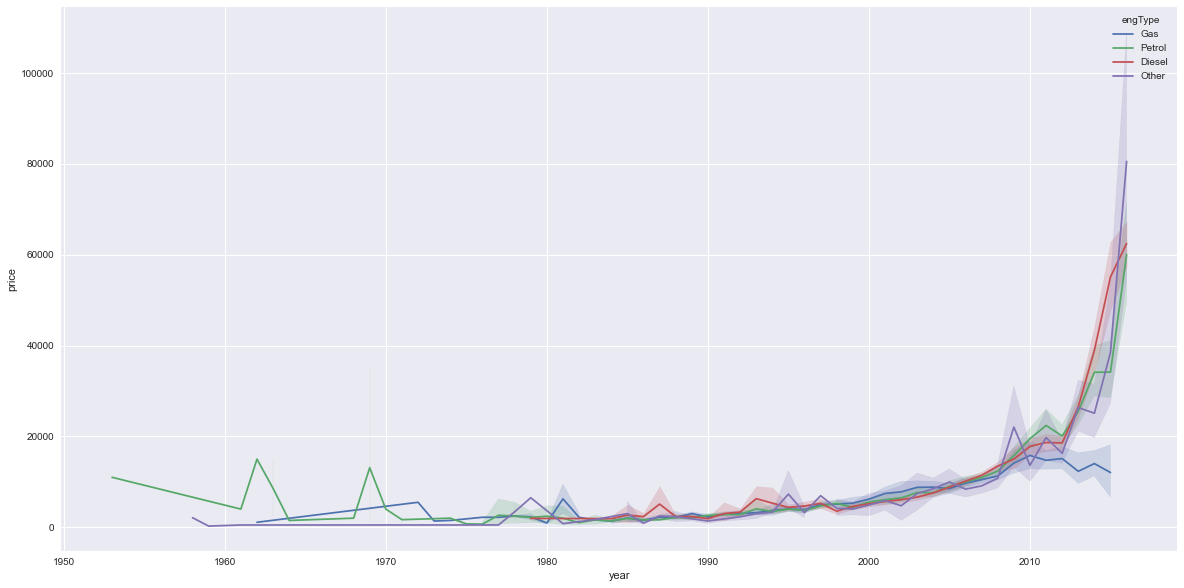

In [164]:
plt.figure(figsize=(20,10))
sns.lineplot(data=carsales_df, x='year', y='price', hue='engType')

In [165]:
classsalesByEngType_5year = carsales_df[carsales_df.year.isin(pd.DataFrame(carsales_df.year.unique())[0].nlargest())].groupby('year')['engType'].value_counts()

In [166]:
carsalesEngType = pd.DataFrame(classsalesByEngType_5year)
carsalesEngType

engType
year engType         
2012 Petrol       332
     Diesel       317
     Gas           75
     Other         36
2013 Petrol       299
     Diesel       234
     Other         59
     Gas           49
2014 Petrol       151
     Diesel       136
     Other         36
     Gas           31
2015 Petrol       119
     Diesel        88
     Other         23
     Gas           10
2016 Diesel       201
     Petrol       192
     Other         22

In [167]:
carsalesEngType.rename(columns={'engType':'Sales'}, inplace=True)

In [168]:
carsalesEngType.reset_index(inplace=True)
carsalesEngType

,year,engType,Sales
0,2012,Petrol,332
1,2012,Diesel,317
2,2012,Gas,75
3,2012,Other,36
4,2013,Petrol,299
5,2013,Diesel,234
6,2013,Other,59
7,2013,Gas,49
8,2014,Petrol,151
9,2014,Diesel,136


In [169]:
# Carsales for last 5 years by engType

#sales_5yrs[sales_5yrs['engType'] == 'Gas']

def get_SalesByEngType(engType):
    return carsalesEngType[carsalesEngType['engType'] == engType]

In [170]:
get_SalesByEngType('Gas')

,year,engType,Sales
2,2012,Gas,75
7,2013,Gas,49
11,2014,Gas,31
15,2015,Gas,10


In [171]:
get_SalesByEngType('Petrol')

,year,engType,Sales
0,2012,Petrol,332
4,2013,Petrol,299
8,2014,Petrol,151
12,2015,Petrol,119
17,2016,Petrol,192


In [172]:
get_SalesByEngType('Diesel')

,year,engType,Sales
1,2012,Diesel,317
5,2013,Diesel,234
9,2014,Diesel,136
13,2015,Diesel,88
16,2016,Diesel,201


In [173]:
get_SalesByEngType('Other')

,year,engType,Sales
3,2012,Other,36
6,2013,Other,59
10,2014,Other,36
14,2015,Other,23
18,2016,Other,22


In [174]:
# For last 5 years car sales based on engType, body, class and average price


salesByEngTypeBodyClass_df = carsales_df[carsales_df.year.isin(pd.DataFrame(carsales_df.year.unique())[0].nlargest(10))]

In [175]:
salesByEngTypeBodyClass_df

,car,price,body,mileage,engV,engType,registration,year,model,drive,class
0,Ford,15500,crossover,68,2,Gas,yes,2010,Kuga,full,Luxury
1,Mercedes-Benz,20500,sedan,173,2,Gas,yes,2011,E-Class,rear,Luxury
2,Mercedes-Benz,35000,other,135,6,Petrol,yes,2008,CL 550,rear,Premium
3,Mercedes-Benz,17800,van,162,2,Diesel,yes,2012,B 180,front,Luxury
4,Mercedes-Benz,33000,vagon,91,3,Other,yes,2013,E-Class,rear,Premium
...,...,...,...,...,...,...,...,...,...,...,...
9570,Toyota,14474,crossover,115,2,Petrol,yes,2007,Rav 4,full,Luxury
9571,Hyundai,14500,crossover,140,2,Gas,yes,2011,Tucson,front,Luxury
9573,Mercedes-Benz,18500,crossover,180,4,Petrol,yes,2008,ML 350,full,Luxury
9574,Lexus,16999,sedan,150,4,Gas,yes,2008,ES 350,front,Luxury


In [176]:
salesByYearBodyClass = salesByEngTypeBodyClass_df.pivot_table(index=['year','engType'], values='price', aggfunc='mean')

In [177]:
salesByYearBodyClass.reset_index(inplace=True)

In [178]:
salesByYearBodyClass

,year,engType,price
0,2007,Diesel,11429
1,2007,Gas,10494
2,2007,Other,9112
3,2007,Petrol,10965
4,2008,Diesel,13465
5,2008,Gas,11289
6,2008,Other,10794
7,2008,Petrol,12373
8,2009,Diesel,15019
9,2009,Gas,14122


In [179]:
def get_carPrice(eng):
    return salesByYearBodyClass[(salesByYearBodyClass.engType == eng)]

In [180]:
get_carPrice('Petrol')

,year,engType,price
3,2007,Petrol,10965
7,2008,Petrol,12373
11,2009,Petrol,15761
15,2010,Petrol,19504
19,2011,Petrol,22412
23,2012,Petrol,20097
27,2013,Petrol,25509
31,2014,Petrol,34119
35,2015,Petrol,34162
38,2016,Petrol,60017


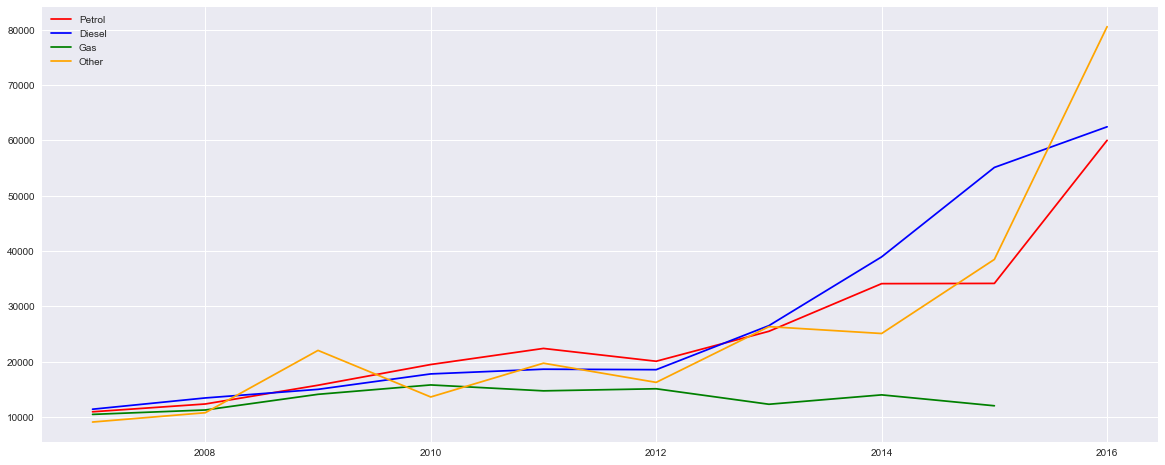

In [181]:
petrolCarPrice = get_carPrice('Petrol')
dieselCarPrice = get_carPrice('Diesel')
gasCarPrice = get_carPrice('Gas')
otherCarPrice = get_carPrice('Other')

plt.figure(figsize=(20, 8))
plt.plot(petrolCarPrice.year, petrolCarPrice.price, color="r", label="Petrol")
plt.plot(dieselCarPrice.year, dieselCarPrice.price, color="b", label="Diesel")
plt.plot(gasCarPrice.year, gasCarPrice.price, color="g", label="Gas")
plt.plot(otherCarPrice.year, otherCarPrice.price, color="orange", label="Other")
plt.legend()

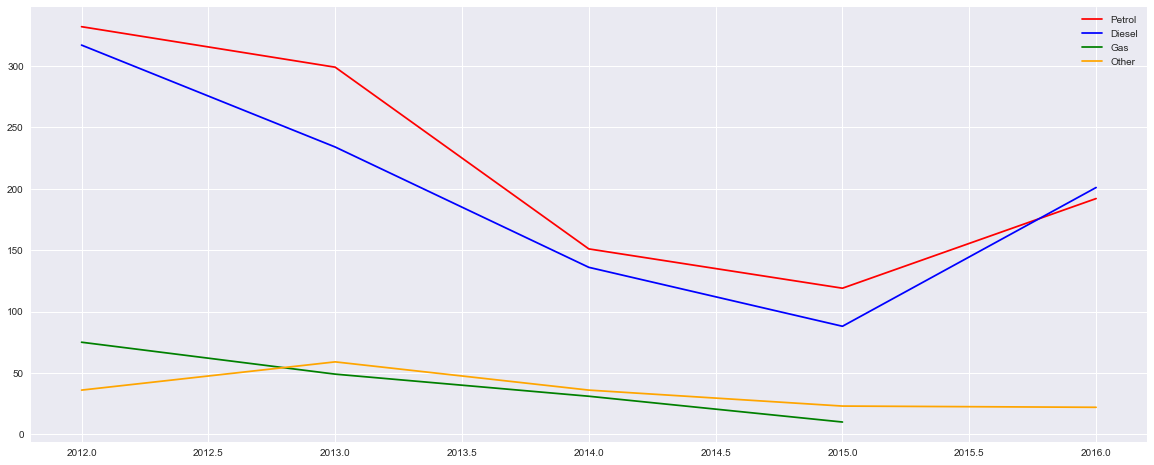

In [182]:
petrolCarSales = get_SalesByEngType('Petrol')
dieselCarSales = get_SalesByEngType('Diesel')
gasCarSales = get_SalesByEngType('Gas')
otherCarSales = get_SalesByEngType('Other')

plt.figure(figsize=(20, 8))
plt.plot(petrolCarSales.year, petrolCarSales.Sales, color="r", label="Petrol")
plt.plot(dieselCarSales.year, dieselCarSales.Sales, color="b", label="Diesel")
plt.plot(gasCarSales.year, gasCarSales.Sales, color="g", label="Gas")
plt.plot(otherCarSales.year, otherCarSales.Sales, color="orange", label="Other")
plt.legend()

<AxesSubplot:xlabel='engType', ylabel='count'>

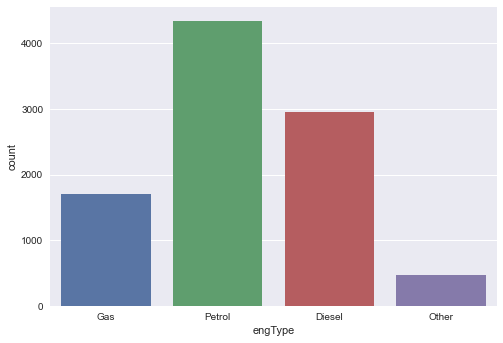

In [183]:
sns.countplot(x='engType', data=carsales_df, orient='h')

<AxesSubplot:xlabel='engType', ylabel='count'>

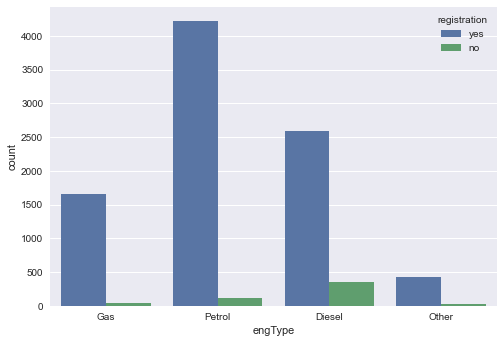

In [184]:
sns.countplot(x='engType', data=carsales_df, orient='h', hue='registration')

<AxesSubplot:xlabel='body', ylabel='count'>

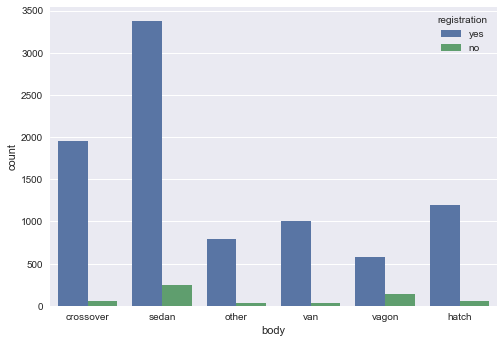

In [185]:
sns.countplot(x='body', data=carsales_df, orient='h', hue='registration')

D:\ProgramData\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


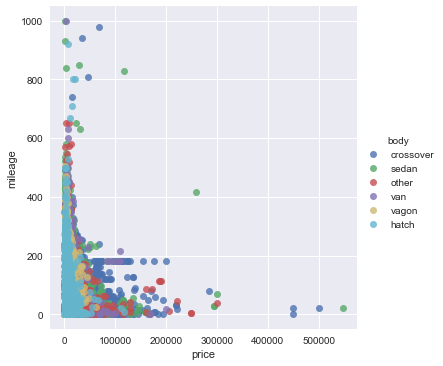

In [186]:

sns.lmplot('price','mileage', carsales_df, fit_reg=False, hue='body')

Text(0, 0.5, 'Average Price')

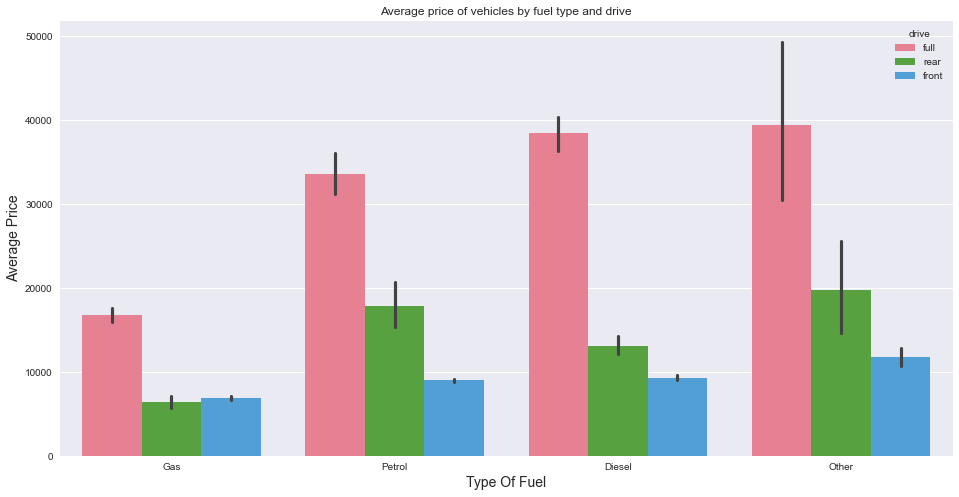

In [187]:

fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(x="engType", y="price", hue= "drive", palette="husl",data=carsales_df)
ax.set_title("Average price of vehicles by fuel type and drive",fontdict= {'size':12})
ax.xaxis.set_label_text("Type Of Fuel",fontdict= {'size':14})
ax.yaxis.set_label_text("Average Price",fontdict= {'size':14})


In [188]:
carsales_df[(carsales_df.drive =='full') & (carsales_df.engType == 'Petrol')].price.mean()

33500.22741591993

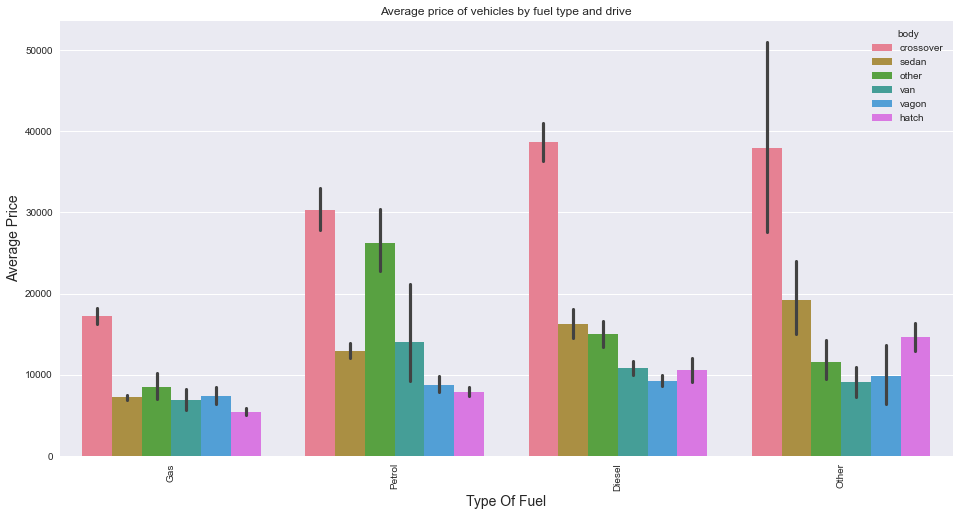

In [189]:
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(x="engType", y="price", hue= "body", palette="husl",data=carsales_df)
ax.set_title("Average price of vehicles by fuel type and drive",fontdict= {'size':12})
ax.xaxis.set_label_text("Type Of Fuel",fontdict= {'size':14})
ax.yaxis.set_label_text("Average Price",fontdict= {'size':14})
ticks = plt.setp(ax.get_xticklabels(),rotation=90)

<AxesSubplot:xlabel='drive', ylabel='count'>

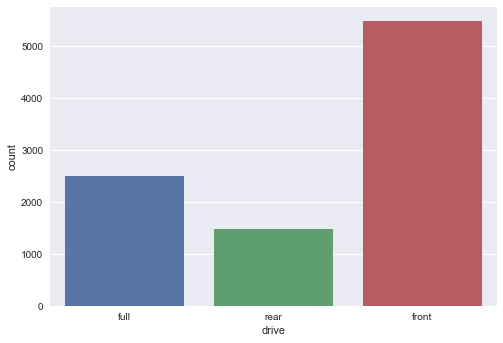

In [190]:
sns.countplot(x='drive', data=carsales_df, orient='h')

<AxesSubplot:xlabel='drive', ylabel='count'>

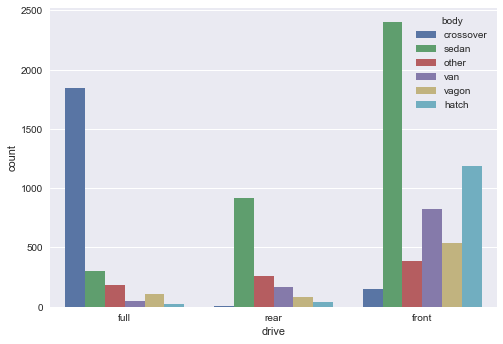

In [191]:
sns.countplot(x='drive', data=carsales_df, orient='h', hue='body')

In [192]:
def get_previousYearsCarSales(n):
    return carsales_df[carsales_df.year.isin(pd.DataFrame(carsales_df.year.unique())[0].nlargest(n))]

<AxesSubplot:xlabel='drive', ylabel='count'>

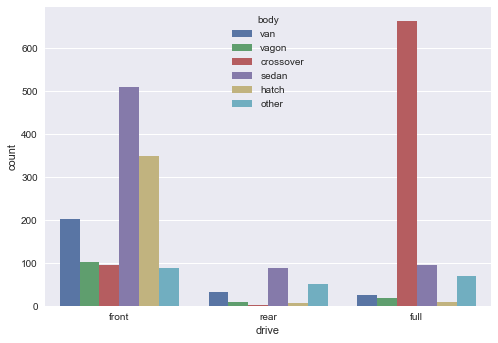

In [193]:
sns.countplot(x='drive', data=get_previousYearsCarSales(5), orient='h', hue='body')

<AxesSubplot:xlabel='drive', ylabel='count'>

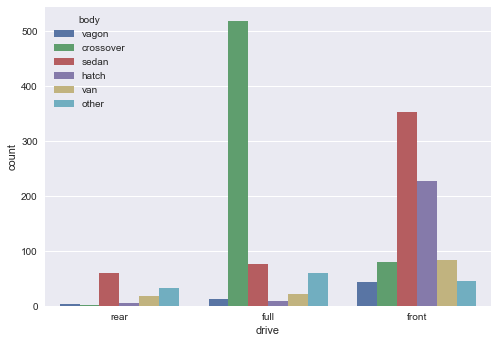

In [194]:
sns.countplot(x='drive', data=get_previousYearsCarSales(4), orient='h', hue='body')

<AxesSubplot:xlabel='drive', ylabel='count'>

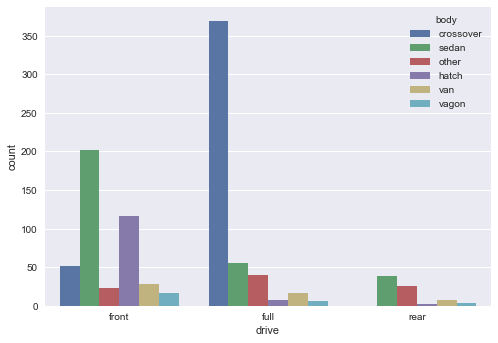

In [195]:
sns.countplot(x='drive', data=get_previousYearsCarSales(3), orient='h', hue='body')

<AxesSubplot:xlabel='drive', ylabel='count'>

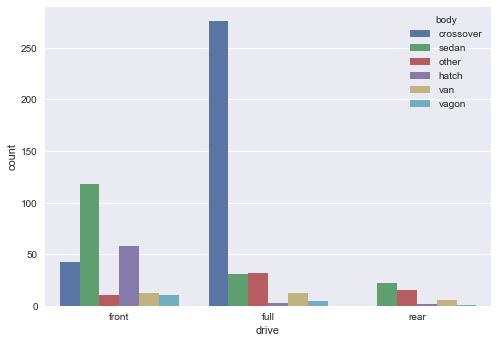

In [196]:
sns.countplot(x='drive', data=get_previousYearsCarSales(2), orient='h', hue='body')

<AxesSubplot:xlabel='drive', ylabel='count'>

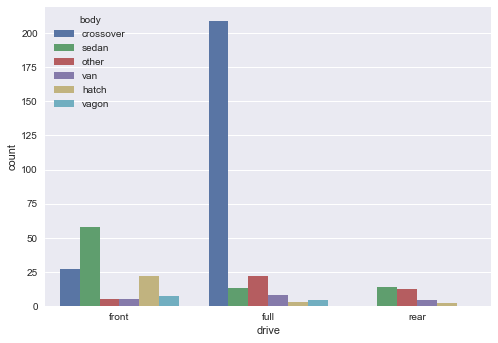

In [197]:
sns.countplot(x='drive', data=get_previousYearsCarSales(1), orient='h', hue='body')

In [199]:
salesByYearBodyClass

,year,engType,price
0,2007,Diesel,11429
1,2007,Gas,10494
2,2007,Other,9112
3,2007,Petrol,10965
4,2008,Diesel,13465
5,2008,Gas,11289
6,2008,Other,10794
7,2008,Petrol,12373
8,2009,Diesel,15019
9,2009,Gas,14122


In [211]:
def get_priceByYearEngType(r):
    #print(r.engType)
    return carsales_df[(carsales_df.year == r.year) & (carsales_df.engType == r.engType)].car.count()

In [202]:
#get_priceByYearEngType(2016,'Petrol')

192

In [212]:
salesByYearBodyClass['sales'] = salesByYearBodyClass.apply(get_priceByYearEngType, axis=1)


In [213]:
salesByYearBodyClass

,year,engType,price,sales
0,2007,Diesel,11429,209
1,2007,Gas,10494,238
2,2007,Other,9112,38
3,2007,Petrol,10965,444
4,2008,Diesel,13465,250
5,2008,Gas,11289,256
6,2008,Other,10794,47
7,2008,Petrol,12373,597
8,2009,Diesel,15019,99
9,2009,Gas,14122,59


In [215]:
def get_carpricesales(et):
    return salesByYearBodyClass[salesByYearBodyClass.engType == et]

In [225]:
def plotGraph(et):
    carSalesPrice = get_carpricesales(et)
    plt.figure(figsize=(20, 8))
    ax = carSalesPrice.plot('year','sales')
    carSalesPrice.plot('year','price',secondary_y=True, ax=ax)
    plt.legend()

<Figure size 1440x576 with 0 Axes>

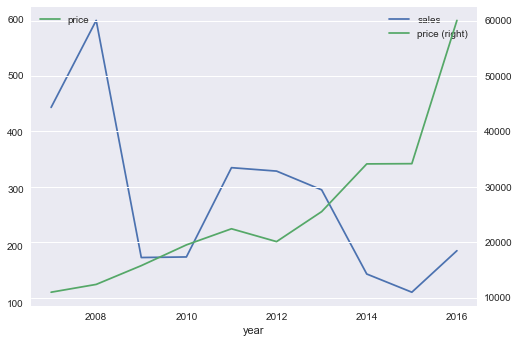

In [229]:
plotGraph('Petrol')

<Figure size 1440x576 with 0 Axes>

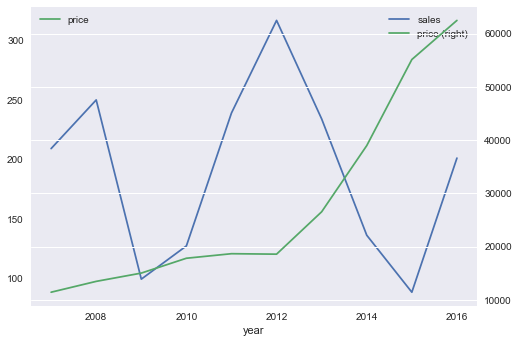

In [226]:
plotGraph('Diesel')

<Figure size 1440x576 with 0 Axes>

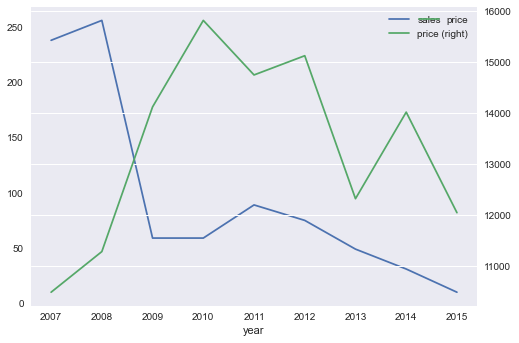

In [227]:
plotGraph('Gas')

<Figure size 1440x576 with 0 Axes>

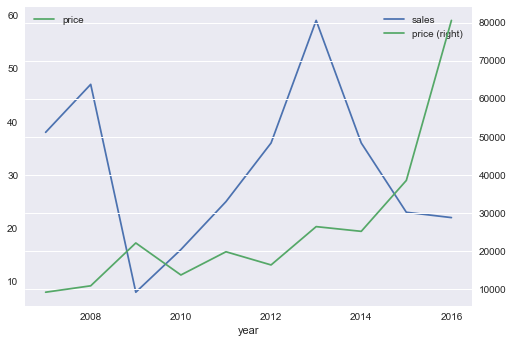

In [228]:
plotGraph('Other')

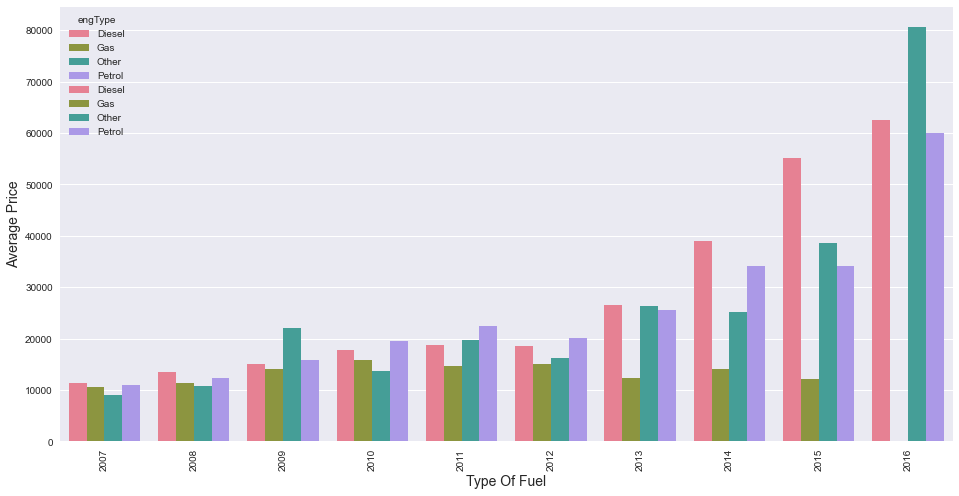

In [232]:
fig, ax = plt.subplots(figsize=(16,8))

sns.barplot(x="year", y="price", hue= "engType", palette="husl",data=salesByYearBodyClass)


ax.xaxis.set_label_text("Type Of Fuel",fontdict= {'size':14})
ax.yaxis.set_label_text("Average Price",fontdict= {'size':14})
ticks = plt.setp(ax.get_xticklabels(),rotation=90)

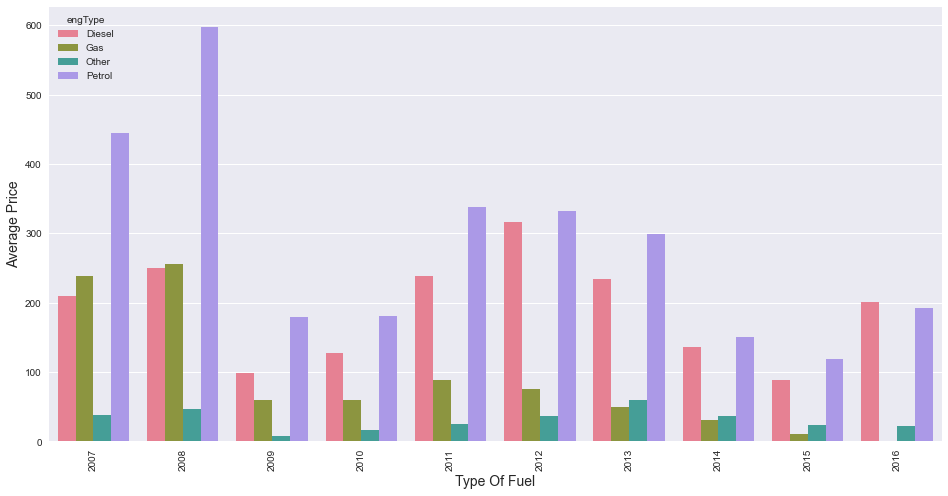

In [233]:
fig, ax = plt.subplots(figsize=(16,8))
sns.barplot(x="year", y="sales", hue= "engType", palette="husl",data=salesByYearBodyClass)
ax.xaxis.set_label_text("Type Of Fuel",fontdict= {'size':14})
ax.yaxis.set_label_text("Average Price",fontdict= {'size':14})
ticks = plt.setp(ax.get_xticklabels(),rotation=90)

<Figure size 1440x576 with 0 Axes>

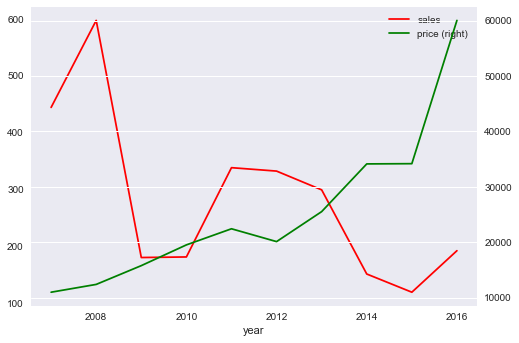

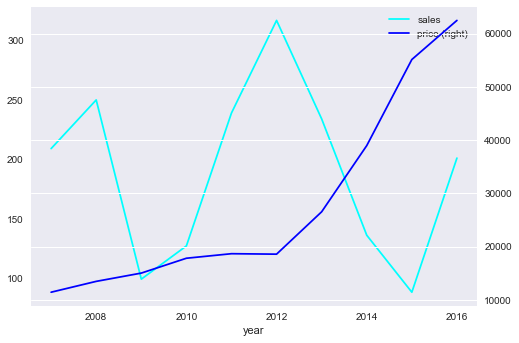

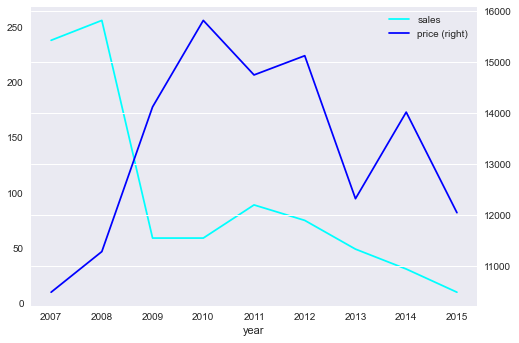

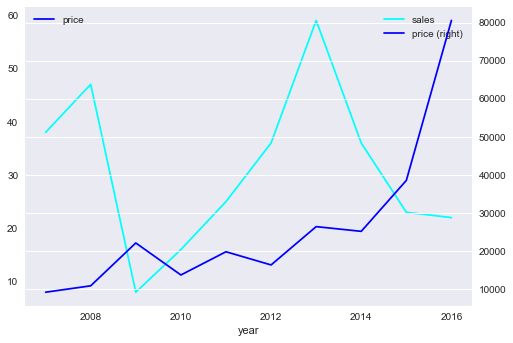

In [243]:
petrolcarSalesPrice = get_carpricesales('Petrol')
dieselCarSalesPrice = get_carpricesales('Diesel')
gasCarSalesPrice = get_carpricesales('Gas')
otherCarSalesPrice = get_carpricesales('Other')

plt.figure(figsize=(20, 8))
ax = petrolcarSalesPrice.plot('year','sales', color='r')
petrolcarSalesPrice.plot('year','price', color='g', secondary_y=True, ax=ax)

ax = dieselCarSalesPrice.plot('year','sales', color='aqua')
dieselCarSalesPrice.plot('year','price', color='blue', secondary_y=True, ax=ax)

ax = gasCarSalesPrice.plot('year','sales', color='aqua')
gasCarSalesPrice.plot('year','price', color='blue', secondary_y=True, ax=ax)

ax = otherCarSalesPrice.plot('year','sales', color='aqua')
otherCarSalesPrice.plot('year','price', color='blue', secondary_y=True, ax=ax)

plt.legend()





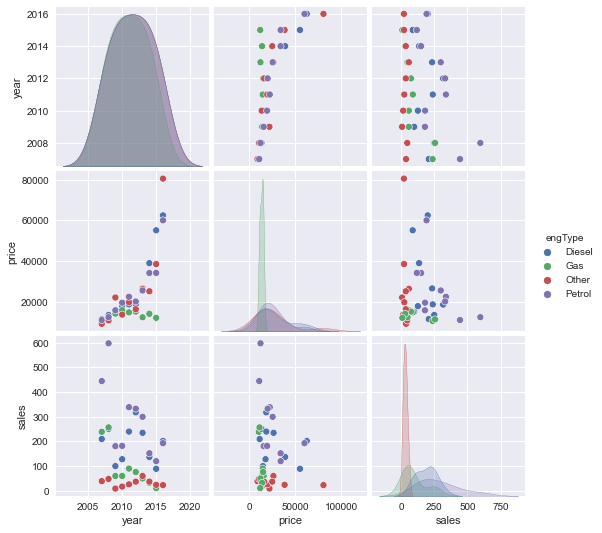

In [245]:
sns.pairplot(data=salesByYearBodyClass, hue='engType')

<AxesSubplot:xlabel='sales', ylabel='price'>

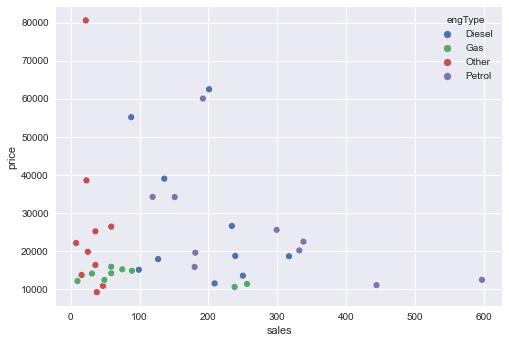

In [253]:
sns.scatterplot(data=salesByYearBodyClass, x='sales', y='price', hue='engType')

In [256]:
carsales_yearbody = carsales_df.pivot_table(index=['year','body'], values='car', aggfunc='count')

In [258]:
carsales_yearbody.rename(columns={'car':'sales'}, inplace=True)
carsales_yearbody

sales
year body        
1953 sedan      1
1958 other      1
1959 sedan      1
1961 other      1
     sedan      1
...           ...
2016 hatch     27
     other     39
     sedan     85
     vagon     11
     van       17

[235 rows x 1 columns]

In [260]:
carsales_yearbody.reset_index(inplace=True)
carsales_yearbody


,year,body,sales
0,1953,sedan,1
1,1958,other,1
2,1959,sedan,1
3,1961,other,1
4,1961,sedan,1
...,...,...,...
230,2016,hatch,27
231,2016,other,39
232,2016,sedan,85
233,2016,vagon,11


In [265]:
def get_carpricebybodyyear(r):
    return (carsales_df[(carsales_df.body == r.body) & (carsales_df.year == r.year)].price.mean())

In [267]:
carsales_yearbody['price'] = carsales_yearbody.apply(get_carpricebybodyyear, axis=1)

In [268]:
carsales_yearbody

,year,body,sales,price
0,1953,sedan,1,11000
1,1958,other,1,2100
2,1959,sedan,1,259
3,1961,other,1,4000
4,1961,sedan,1,500
...,...,...,...,...
230,2016,hatch,27,20615
231,2016,other,39,76072
232,2016,sedan,85,41867
233,2016,vagon,11,20119


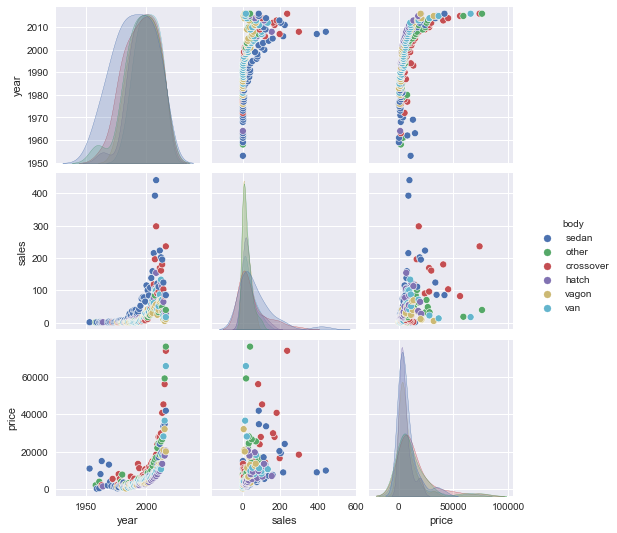

In [272]:
sns.pairplot(data=carsales_yearbody, hue="body")

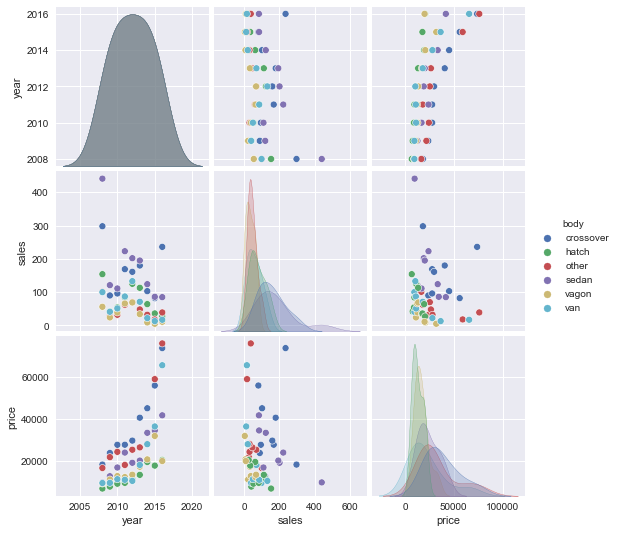

In [276]:
sns.pairplot(data=carsales_yearbody[carsales_yearbody.year > 2007], hue="body")

<AxesSubplot:xlabel='sales', ylabel='price'>

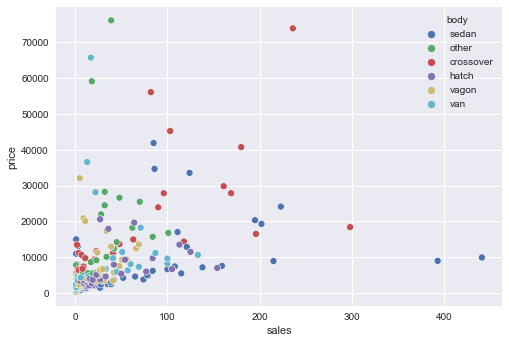

In [270]:
sns.scatterplot(data=carsales_yearbody, x='sales', y='price', hue='body')

<AxesSubplot:xlabel='sales', ylabel='price'>

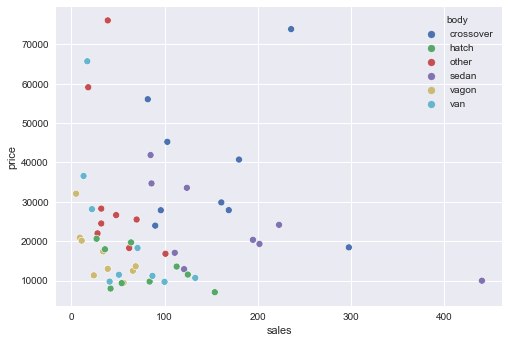

In [274]:
sns.scatterplot(data=carsales_yearbody[carsales_yearbody.year > 2007], x='sales', y='price', hue='body')

<AxesSubplot:xlabel='sales', ylabel='price'>

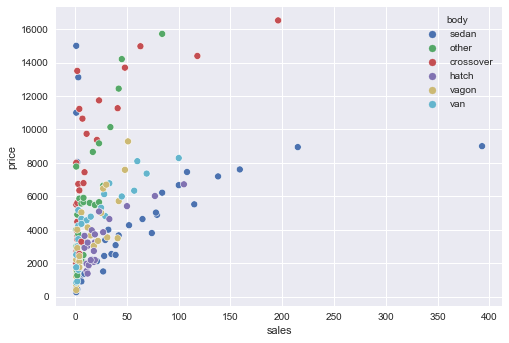

In [275]:
sns.scatterplot(data=carsales_yearbody[carsales_yearbody.year <= 2007], x='sales', y='price', hue='body')

<AxesSubplot:xlabel='sales', ylabel='year'>

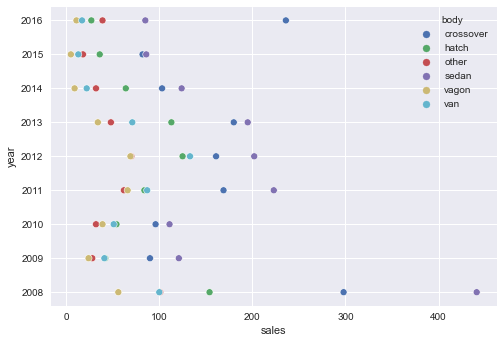

In [277]:
sns.scatterplot(data=carsales_yearbody[carsales_yearbody.year > 2007], x='sales', y='year', hue='body')

<AxesSubplot:xlabel='sales', ylabel='year'>

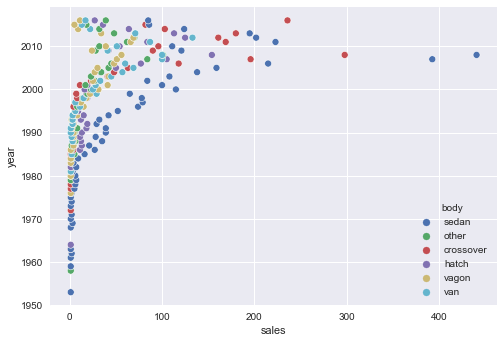

In [278]:
sns.scatterplot(data=carsales_yearbody, x='sales', y='year', hue='body')

In [282]:
pd.DataFrame(carsales_df[carsales_df.year.isin(pd.DataFrame(carsales_df.year.unique())[0].nlargest())].groupby(['engType', 'year']))

,0,1
0,"(Diesel, 2012)",car price body mileage...
1,"(Diesel, 2013)",car price body mileage e...
2,"(Diesel, 2014)",car price body mileage...
3,"(Diesel, 2015)",car price body mileage e...
4,"(Diesel, 2016)",car price body mileage e...
5,"(Gas, 2012)",car price body mileage...
6,"(Gas, 2013)",car price body mileage...
7,"(Gas, 2014)",car price body mileage e...
8,"(Gas, 2015)",car price body mileage en...
9,"(Other, 2012)",car price body mileage...


In [326]:
carsalesrecent_df = carsales_df[carsales_df.year.isin(pd.DataFrame(carsales_df.year.unique())[0].nlargest())]

In [327]:
carsalesrecent_pv = carsalesrecent_df.pivot_table(index=['engType'], values='car', aggfunc="count")

In [328]:
carsalesrecent_pv.rename(columns={'car':'sales'}, inplace=True)


In [329]:
#carsalesrecent_pv.reset_index(inplace=True)
carsalesrecent_pv

,sales
engType,
Diesel,976
Gas,165
Other,176
Petrol,1093


In [330]:
carsalesold_df = carsales_df[carsales_df.year < 2012]
carsalesold_pv = carsalesold_df.pivot_table(index=['engType'], values='car', aggfunc="count")
carsalesold_pv.rename(columns={'car':'sales'}, inplace=True)
#carsalesold_pv.reset_index(inplace=True)
#carsalesold_pv

<AxesSubplot:ylabel='sales'>

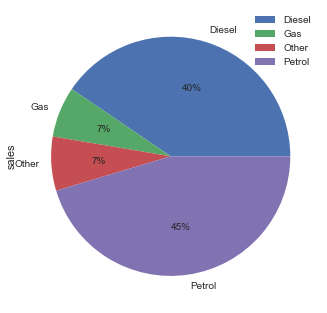

In [340]:
carsalesrecent_pv.plot.pie(y='sales', x='engType', autopct="%0.0f%%")

<AxesSubplot:ylabel='sales'>

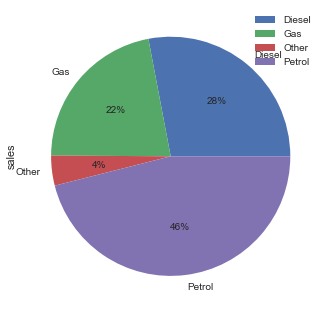

In [338]:
carsalesold_pv.plot.pie(y='sales', x='engType', autopct="%0.0f%%")

In [339]:
carsalesold_pv

,sales
engType,
Diesel,1974
Gas,1545
Other,286
Petrol,3248


## Conclusions:

* From the recent past the car sales are stagnated on Gas type. In other hand
    * Petrol car sales are consistent
    * Diesel car sales are gaining momentum
    * Other car sales are gradullay increasing
    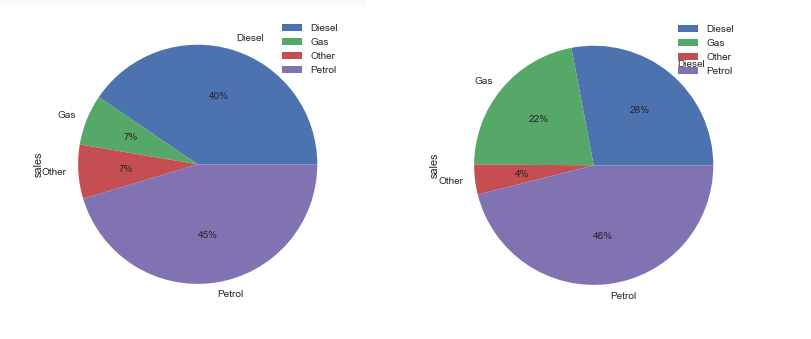
    
* Even with effordable price range, gas and other engine type cars are least preferred.
* Most preferred 
    * engine types are Petrol and Diesel
    * body types are cross-overs and sedan
* Irrespective of tenure, Sedans are always on demand follows with Cross-over and hatch.




## Recommendations

* Top 20 brands need to considers for future procurement, rest can provided with better deals to customer
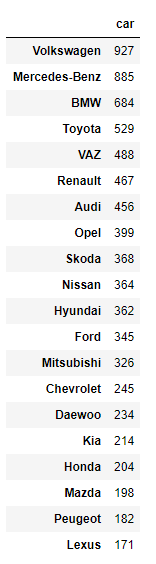
* Company has more focus on luxury and premiums cars than economy.

In [343]:
pd.DataFrame(carsales_df.car.value_counts()).head(20)

,car
Volkswagen,927
Mercedes-Benz,885
BMW,684
Toyota,529
VAZ,488
Renault,467
Audi,456
Opel,399
Skoda,368
Nissan,364
